In [1]:
!pip install svgpath2mpl

In [2]:

from collections import namedtuple, deque
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adamax
import random
import math 
from svgpath2mpl import parse_path
import matplotlib.pyplot as plt
import imageio
import gc
import time
import matplotlib
from scipy.ndimage import rotate, shift

In [3]:
from collections import  deque, namedtuple
import random
Transition = namedtuple('Transition',('belief_map', 'state_vector', 'last_action', 'action', 'next_belief_map', 'next_state_vector', 'reward'))

class EpisodeMemory:

  def __init__(self):
    self.episode_scene = []

  def push(self, *args):
    self.episode_scene.append(Transition(*args))

  def sample(self, batch_size):
    start_idx = random.randint(0, len(self.episode_scene)-batch_size)
    return self.episode_scene[start_idx:start_idx+batch_size]

  def __len__(self):
    return len(self.episode_scene)

class ReplayMemory:
  def __init__(self, capacity):
    self.episodes = deque([], maxlen=capacity)

  def push(self, episode):
    self.episodes.append(episode)

  def sample(self, batch_size):
    
    episode = random.sample(self.episodes, 1)[0]
    return episode.sample(batch_size)

  def __len__(self):
    return len(self.episodes)


In [4]:
from abc import ABCMeta, abstractmethod
import numpy as np
class AbstractFireEnv(metaclass = ABCMeta):

  def __init__(self, _height, _width):
    self._height = _height
    self._width  = _width
    self._time_steps = 0
    self._observation = None

  @property
  def height(self):
    return self._height
  
  @property
  def width(self):
    return self._width

  @property 
  def time_steps(self):
    return self._time_steps

  @time_steps.setter
  def time_steps(self, _time_steps):
    self._time_steps = _time_steps

  @property
  def observation(self):
    return self._observation

  @observation.setter
  def observation(self, _observation):
    self._observation = _observation

  def step(self):
    self._time_steps += 1
    self.observation = self.next_observation()
    return self.observation

  def plot_heat_map(self, fig, ax):
    ax.axis(xmin=0, xmax=self._width)
    ax.axis(ymin=0, ymax=self._height)  
    heat_map_plot = ax.imshow(self.observation, cmap='hot')
    return heat_map_plot

  def reset(self):
    self._time_steps = 0
    self.observation = self.reset_observation()
    seed = self.observation.copy()
    for _ in range(30):
      self.step()
    return seed, self.observation

  def fire_in_range(self,margin=2):
    burnX, burnY = np.where(self.observation==1)
    return min(burnX)>=margin and min(burnY)>=margin and max(burnX)<=99-margin and max(burnY)<=99-margin

  @abstractmethod
  def next_observation(self):
    pass

  @abstractmethod
  def reset_observation(self):
    pass

In [5]:
import numpy as np
import random
HEIGHT = 100
WIDTH = 100
D = 2
K = 0.05

def getNeighbors(point):
    neighbors = []
    min_x = max(0, point[1]-D)
    max_x = min(99, point[1]+D)
    min_y = max(0, point[0]-D)
    max_y = min(99, point[0]+D)

    for y in range(min_y, max_y): 
      for x in range(min_x, max_x):
        neighbors.append((y, x))
    return neighbors

class ProbabilisticFireEnv(AbstractFireEnv):

  def next_observation(self):

    probability_map = np.zeros(shape=(HEIGHT,WIDTH), dtype=float)
    for row in range(self.height):
      for col in range(self.width):
        if self.observation[row,col] == 1:
          if self.fuel[row, col] > 0:
            self.fuel[row, col] -= 1
          else:
            self.observation[row,col] = 0

        elif self.observation[row,col] == 0 and self.fuel[row, col] > 0:
          neighboring_cells = getNeighbors((row, col))
          pnm = 1
          for neighboring_cell in neighboring_cells:
            if self.observation[neighboring_cell] == 1:
              dnmkl = np.array([a-b for a, b in zip(neighboring_cell, (row,col))])
              norm = np.sum(dnmkl**2)
              pnmkl0 = K/norm
              pnmklw = K*(dnmkl @ self.wind)/norm 
              pnmkl  = max(0, min(1, (pnmkl0+pnmklw)))
              pnm *= (1-pnmkl)
          pmn = 1 - pnm
          probability_map[row, col] = pmn

    self.observation[probability_map > np.random.rand(HEIGHT,WIDTH)]  = 1

    return self.observation

  def reset_observation(self):
    center = [49, 49]
    self.observation = np.zeros(shape=(self.height, self.width), dtype=int)
    self.observation[center[0]-2:center[0]+2, center[1]-2:center[1]+2] = 1
    self.fuel = np.random.randint(low=15, high=20, size=(self.height, self.width))
    self.wind = np.random.uniform(low=-0.25, high=0.25, size=2)
    return self.observation

In [6]:
from svgpath2mpl import parse_path
import matplotlib.pyplot as plt
import matplotlib
from scipy.ndimage import rotate, shift
import numpy as np
import math
import random
import random

HEIGHT = WIDTH = 100
C = 50
Cx = 50
Cy = 50

VELOCITY = 2
GRAVITY  = 0.981
MINRANGE = 15   # Minimium initial distance from wildfire seed
MAXRANGE = 30   # Maximum initial distance from wildfire seed
BANK_ANGLE_DELTA  = 5

plane_marker = parse_path('M 11.640625 15.0625 L 9.304688 13.015625 L 9.300781 9.621094 L 15.125 11.511719 L 15.117188 10.109375 L 9.257812 5.535156 L 9.25 2.851562 L 9.25 1.296875 C 9.253906 1.019531 9.140625 0.777344 8.960938 0.585938 C 8.738281 0.324219 8.410156 0.15625 8.039062 0.160156 C 8.027344 0.160156 8.011719 0.164062 8 0.164062 C 7.988281 0.164062 7.972656 0.160156 7.960938 0.160156 C 7.589844 0.15625 7.257812 0.324219 7.035156 0.585938 C 6.859375 0.777344 6.746094 1.019531 6.746094 1.296875 L 6.746094 2.851562 L 6.742188 5.535156 L 0.882812 10.109375 L 0.875 11.511719 L 6.699219 9.621094 L 6.691406 13.011719 L 4.359375 15.0625 L 4.355469 15.761719 L 4.628906 15.695312 L 4.628906 15.839844 L 7.511719 14.992188 L 8 14.875 L 8.484375 14.992188 L 11.371094 15.839844 L 11.375 15.695312 L 11.644531 15.761719 Z M 11.640625 15.0625 ')
plane_marker.vertices -= plane_marker.vertices.mean(axis=0)
#plane_marker = plane_marker.transformed(matplotlib.transforms.Affine2D().rotate_deg(180))

def euclidean_distance(x1, y1, x2, y2):
  return math.sqrt((x2-x1)**2+(y2-y1)**2)

def shift_matrix(matrix, x, y, padding_value=0):
  deltaX = Cx-x
  deltaY = Cy-y


  if deltaX==0 and deltaY==0:
    return matrix

  return shift(matrix, (deltaY, deltaX), cval = padding_value)
  

class Drone:

  def __init__(self, _droneEnv, _dt, _dti):
    self._bank_angle = 0
    self._droneEnv = _droneEnv
    self._trajectory = []
    self._otherDrone = None
    self.dt = _dt
    self.dti = _dti

  def reset(self):
    radius = random.random()*(MAXRANGE-MINRANGE) + MINRANGE
    angle = (random.random()-0.5)*2*np.pi
    self._x = radius*np.cos(angle) + 50
    self._y = radius*np.sin(angle) + 50
    self._bank_angle = 0
    self._trajectory = [(self.x, self.y)]
    self._heading_angle = (random.random()-0.5)*2*np.pi

  @property
  def otherDrone(self):
    return self._otherDrone

  @otherDrone.setter
  def otherDrone(self, _otherDrone):
    self._otherDrone = _otherDrone

  @property
  def trajectory(self):
    return self._trajectory

  @trajectory.setter
  def trajectory(self, _trajectory):
    self._trajectory = _trajectory

  @property
  def x(self):
    return self._x

  @x.setter
  def x(self, _x):
    self._x = _x

  @property
  def y(self):
    return self._y

  @y.setter
  def y(self, _y):
    self._y = _y

  @property
  def mask(self):
    Y, X = np.ogrid[:HEIGHT, :WIDTH]
    dist_from_center = np.sqrt((X - self.x)**2 + (Y-self.y)**2)
    mask = dist_from_center <= self._droneEnv.scan_radius
    return mask


  @property
  def bank_angle(self):
    return self._bank_angle

  @bank_angle.setter
  def bank_angle(self, _bank_angle):
    self._bank_angle = _bank_angle

  @property
  def heading_angle(self):
    return self._heading_angle

  @heading_angle.setter
  def heading_angle(self, _heading_angle):
    self._heading_angle = _heading_angle
  
  @property
  def rho(self):
    return euclidean_distance(self.x, self.y, self.otherDrone.x, self.otherDrone.y)

  @property
  def theta(self):
    _theta = np.arctan2((self.otherDrone.y-self.y),(self.otherDrone.x-self.x)) - self.heading_angle
    
    if (_theta > math.pi):
      _theta -= 2*math.pi
    elif (_theta<-math.pi):
      _theta+= 2*math.pi

    return _theta

  @property
  def psi(self):
    _psi = self.otherDrone.heading_angle - self.heading_angle

    if (_psi > math.pi):
      _psi -= 2*math.pi
    elif (_psi<-math.pi):
      _psi += 2*math.pi

    return _psi
    
  @property
  def state(self):
    return np.array([
        self.bank_angle, 
        self.rho,
        self.theta,
        self.psi,
        self.otherDrone.bank_angle
    ])[np.newaxis,...]

  @property
  def belief_map(self):
    return self._transform_map(self._droneEnv.belief_map_channel.copy())
  
  @property
  def time_elasped_map(self):
    return self._transform_map(self._droneEnv.time_map_channel.copy(), 250.0)/250.0

  def _transform_map(self, map, padding_value=0):
    return rotate(shift_matrix(map, self.x, self.y, padding_value), angle=np.rad2deg(self.heading_angle), reshape=False, cval=padding_value)

  @property
  def observation(self):
    return np.stack((self.time_elasped_map, self.belief_map), axis=0)[np.newaxis,...]
    
  def step(self, input):

    self.x +=  VELOCITY*math.cos(self.heading_angle)
    self.y +=  VELOCITY*math.sin(self.heading_angle)
    self.trajectory.append((self.x, self.y))  
    self.heading_angle += GRAVITY*np.tan(self.bank_angle)/(VELOCITY)

    if (self.heading_angle>np.pi):
      self.heading_angle-=2*np.pi
    elif (self.heading_angle<-math.pi):
      self.heading_angle+=2*np.pi

    action =  5.0*np.pi/180.0 if input==1 else -5.0*np.pi/180.0
    self.bank_angle += action
    

    if self.bank_angle >  50.0*np.pi/180.0 or self.bank_angle < -50.0*np.pi/180.0:
      self.bank_angle -= action

  @property
  def reward(self):

    return self._reward1()+self._reward2()+self._reward3()+self._reward4()
      


  def plot_time_elapsed(self, fig, ax):

    ax.axis(xmin=0, xmax=WIDTH)
    ax.axis(ymin=0, ymax=HEIGHT)
    time_elasped_plot = ax.imshow(self.time_elasped_map*250.0, cmap='gray', vmin=0, vmax=250)
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    cbar = plt.colorbar(time_elasped_plot, cax=cax)
    return time_elasped_plot 

  def plot_belief_map(self, fig, ax):

    ax.axis(xmin=0, xmax=WIDTH)
    ax.axis(ymin=0, ymax=HEIGHT)
    belief_map_plot = ax.imshow(self.belief_map, cmap='gray_r', vmin=0, vmax=1)  
    return belief_map_plot


class DronesEnv:
  def __init__(self, _height, _width, _dt, _dti, _scan_radius=10):
    self._drones = [Drone(self, _dt, _dti), Drone(self, _dt, _dti)]
    self._drones[0].otherDrone = self._drones[1]
    self._drones[1].otherDrone = self._drones[0]
    self._height = _height 
    self._width  = _width
    self._scan_radius = _scan_radius

  @property 
  def scan_radius(self):
    return self._scan_radius

  @scan_radius.setter
  def scan_radius(self, _scan_radius):
    self._scan_radius = _scan_radius
        
  def reset(self, seed, fireMap):


    self._drones[0].reset()
    self._drones[1].reset()

    self._belief_map_channel = seed
    self._time_elapsed_channel = np.full(shape=(self._height, self._width), fill_value=250)
    self._scan(fireMap)


  def _reward(self, drone, fireMap):
    return np.count_nonzero(drone.mask & (self._belief_map_channel==0) & (fireMap==1))

  def _scan(self, fireMap):

    mask = self.drones[0].mask | self.drones[1].mask

    self._belief_map_channel[mask] = fireMap[mask]
    
    self._time_elapsed_channel[mask] = 0

    self._time_elapsed_channel[~mask & (self._time_elapsed_channel < 250)] += 1


  @property 
  def belief_map_channel(self):
    return self._belief_map_channel

  @belief_map_channel.setter
  def belief_map_channel(self, _belief_map_channel):
    self._belief_map_channel = _belief_map_channel

  @property 
  def time_map_channel(self):
    return self._time_elapsed_channel

  @time_map_channel.setter
  def time_map_channel(self, _time_elapsed_channel):
    self._time_elapsed_channel = _time_elapsed_channel

  @property
  def drones(self):
    return self._drones

  def step(self, input, fireMap):
    
    rewards = []

    for move, drone in zip(input,self.drones):
      drone.step(move) 
      rewards.append(self._reward(drone, fireMap))

    self._scan(fireMap)
    return rewards

  def plot_time_elapsed(self, fig, ax):
    ax.axis(xmin=0, xmax=WIDTH)
    ax.axis(ymin=0, ymax=HEIGHT)
    time_elasped_plot = ax.imshow(self._time_elapsed_channel, cmap='gray', vmin=0, vmax=250)
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    cbar = plt.colorbar(time_elasped_plot, cax=cax)
    return time_elasped_plot

  def plot_belief_map(self, fig, ax):
    ax.axis(xmin=0, xmax=WIDTH)
    ax.axis(ymin=0, ymax=HEIGHT)
    belief_map_plot = ax.imshow(self._belief_map_channel, cmap='gray_r', vmin=0, vmax=1)
    return belief_map_plot   

  def plot_drones(self, fig, ax):
      
    ax.axis(xmin=0, xmax=self._width)
    ax.axis(ymin=0, ymax=self._height)
    ax.set_aspect(1)
    ax.grid()

    plane_marker_1 = matplotlib.markers.MarkerStyle(marker=plane_marker)
    plane_marker_1._transform = plane_marker_1.get_transform().rotate(self.drones[0].heading_angle)

    plane_marker_2 = matplotlib.markers.MarkerStyle(marker=plane_marker)
    plane_marker_2._transform = plane_marker_2.get_transform().rotate(self.drones[1].heading_angle)

    ax.scatter(self.drones[0].x, self.drones[0].y, marker=plane_marker_1, s=30**2)

    ax.scatter(self.drones[1].x, self.drones[1].y, marker=plane_marker_2, s=30**2)

    heading_line = np.array([0, 50])

    x1 = self._drones[0].x + np.cos(np.deg2rad(-90) + self._drones[0].heading_angle) * heading_line
    y1 = self._drones[0].y + np.sin(np.deg2rad(-90) + self._drones[0].heading_angle) * heading_line

    heading_line = np.array([0, 50])

    x2 = self._drones[1].x + np.cos(np.deg2rad(-90) + self._drones[1].heading_angle) * heading_line
    y2 = self._drones[1].y + np.sin(np.deg2rad(-90) + self._drones[1].heading_angle) * heading_line
    
    ax.plot(x1, y1, '--')
    ax.plot(x2, y2, '--')

  def plot_trajectory(self, fig, ax):
      
    ax.axis(xmin=0, xmax=self._width)
    ax.axis(ymin=0, ymax=self._height)
    ax.set_aspect(1)
    ax.grid()

    plane_marker_1 = matplotlib.markers.MarkerStyle(marker=plane_marker)
    plane_marker_1._transform = plane_marker_1.get_transform().rotate(self._drones[0].heading_angle)

    plane_marker_2 = matplotlib.markers.MarkerStyle(marker=plane_marker)
    plane_marker_2._transform = plane_marker_2.get_transform().rotate(self._drones[1].heading_angle)

    ax.scatter(self.drones[0].x, self.drones[0].y, marker=plane_marker_1, s=30**2)

    ax.scatter(self.drones[1].x, self.drones[1].y, marker=plane_marker_2, s=30**2)

    x1, y1 = zip(*self.drones[0].trajectory)
    x2, y2 = zip(*self.drones[1].trajectory)

    ax.plot(x1, y1, '.')
    ax.plot(x2, y2, '.')

In [7]:
import torch.nn as nn
import torch
import numpy as np
from abc import ABCMeta, abstractmethod

class BaseDQN(nn.Module):

  def _get_conv_out(self):
    o = self.conv(torch.zeros((1, self.channels, self.height, self.width)))
    return int(np.prod(o.size()))

  @property
  def height(self):
    return self._height

  @height.setter
  def height(self, _height):
    self._height = _height

  @property
  def width(self):
    return self._width

  @width.setter
  def width(self, _width):
    self._width = _width

  @property
  def channels(self):
    return self._channels

  @channels.setter
  def channels(self, _channels):
    self._channels = _channels

  @property
  def outputs(self):
    return self._outputs

  @outputs.setter
  def outputs(self, _outputs):
    self._outputs = _outputs
    
  def __init__(self, _channels, _height, _width, _outputs):
    super().__init__()
    
    self.channels = _channels
    self.height = _height
    self.width = _width
    self.outputs = _outputs

  def forward(self, belief_map, state_vector):
    pass

In [8]:
BATCH_SIZE = 64
SEQ_LENGTH = 64
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.1
EPS_DECAY = 200000
INIT_SIZE = 25
TARGET_UPDATE = 1000

In [9]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np

class DRQN(BaseDQN):

  def __init__(self, channels, height, width, outputs):
    super().__init__(channels, height, width, outputs)


    self.fc1  = nn.Sequential(
      nn.Linear(5, 100),
      nn.ReLU(),
      nn.Linear(100, 100),
      nn.ReLU(),
      nn.Linear(100, 100),
      nn.ReLU(),
      nn.Linear(100, 100),
      nn.ReLU(),
      nn.Linear(100, 100),
      nn.ReLU()
    )

    self.conv = nn.Sequential(
      nn.Conv2d(2, 64, kernel_size=3),
      nn.ReLU(),
      nn.MaxPool2d(2, stride=2),
      nn.Conv2d(64, 64, kernel_size=3),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3),
      nn.ReLU(),
      nn.MaxPool2d(2, stride=2)
    )
  
    conv_out_size = self._get_conv_out()

    self.fc2 = nn.Sequential(
      nn.Linear(conv_out_size, 500),
      nn.ReLU(),
      nn.Linear(500, 100),
      nn.ReLU(),
      nn.Linear(100, 100),
      nn.ReLU(),
    )


    self.fc3 = nn.Sequential(
      nn.Linear(200, 200),
      nn.ReLU(),
      nn.Linear(200, 200),
    )
    
    self.lstm = nn.LSTM(input_size = 200, hidden_size = 200, batch_first=True)
    
    self.fc4 = nn.Linear(200, outputs)

  def forward(self, belief_map, state_vector, hidden = None, training=False):
    
    if training:
      state_vector = state_vector.view(-1, 5)
      belief_map   = belief_map.view(-1, 2, 100, 100)
  
    fc1_out = self.fc1(state_vector)
    conv_out = self.conv(belief_map)
    flatten_out = torch.flatten(conv_out, 1)
    fc2_out = self.fc2(flatten_out)
    concatenated = torch.cat((fc1_out, fc2_out), dim=1)
    
    fc3_out = self.fc3(concatenated)
    
    if training:
      fc3_out = fc3_out.view(BATCH_SIZE, SEQ_LENGTH, 200)
    else: 
      fc3_out = fc3_out.view(1, 1, 200)


    if hidden is None:
      lstm_out, hidden_out = self.lstm(fc3_out)
    else:
      lstm_out, hidden_out = self.lstm(fc3_out, hidden)
    

    return self.fc4(lstm_out), hidden_out

In [10]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_actions = 2
screen_height = screen_width = 100
channels = 2
net = DRQN(channels, HEIGHT, WIDTH, n_actions).to(device)

net.load_state_dict(torch.load(f'rnn_target_weights.pt'))
net.eval()

DRQN(
  (fc1): Sequential(
    (0): Linear(in_features=5, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): ReLU()
  )
  (conv): Sequential(
    (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=30976, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=100, bias=True)


In [11]:

def select_action(belief_map, state_vector, hidden):

    output, hidden_out = net(belief_map.cuda(), state_vector.cuda(), hidden)
    return torch.argmax(output).cpu().item(), hidden_out

/tmp/ipykernel_913/3912770387.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 5, figsize=(28, 4))


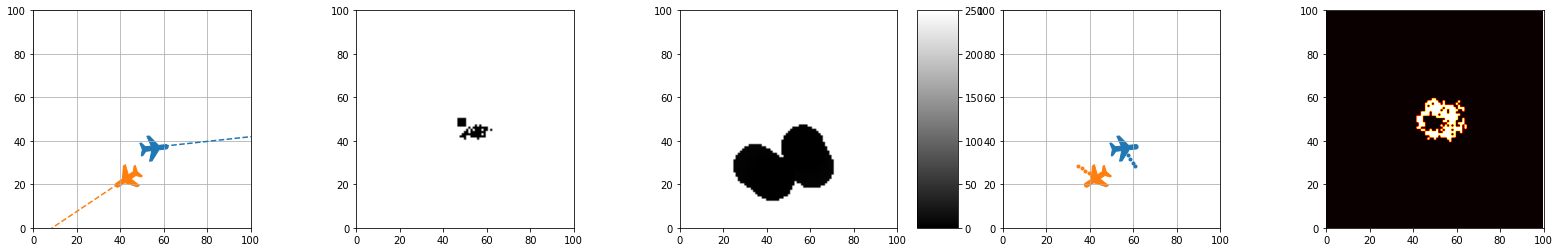

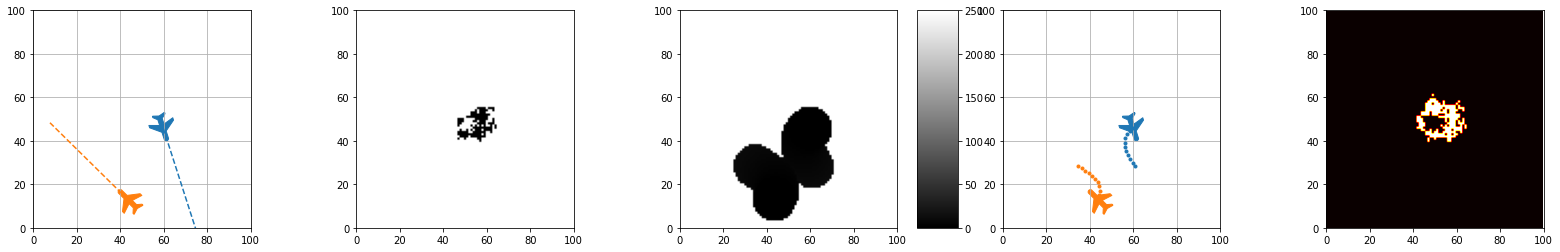

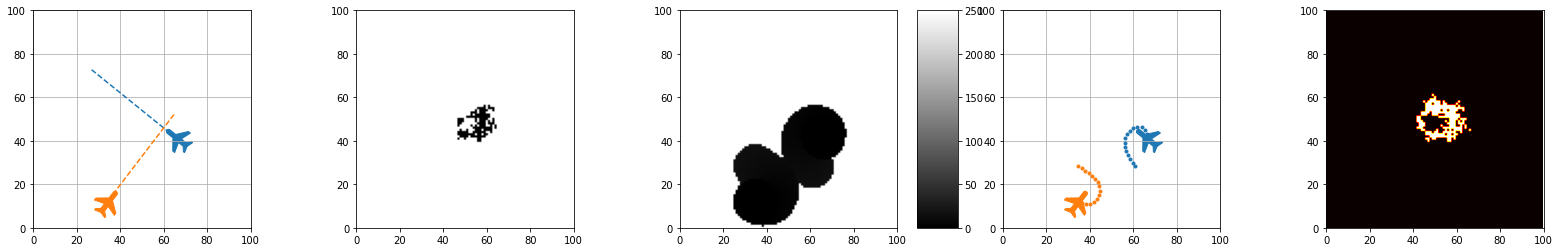

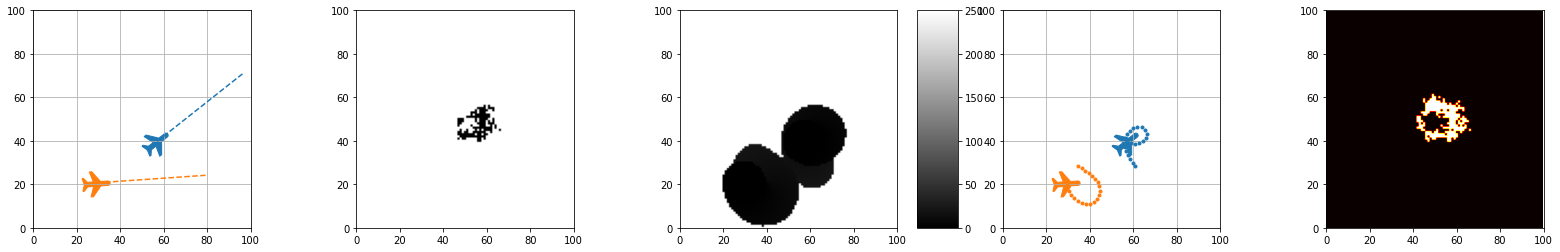

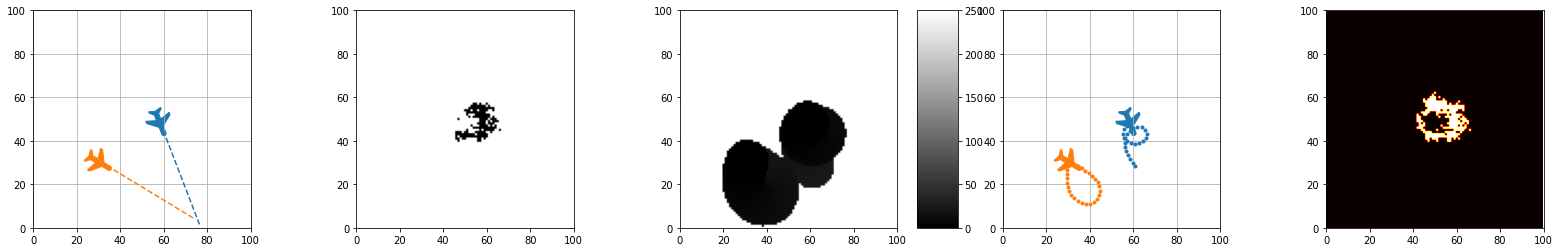

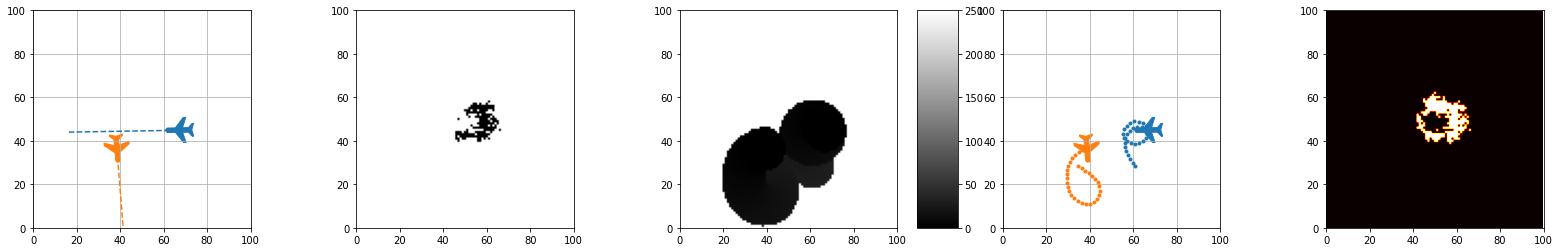

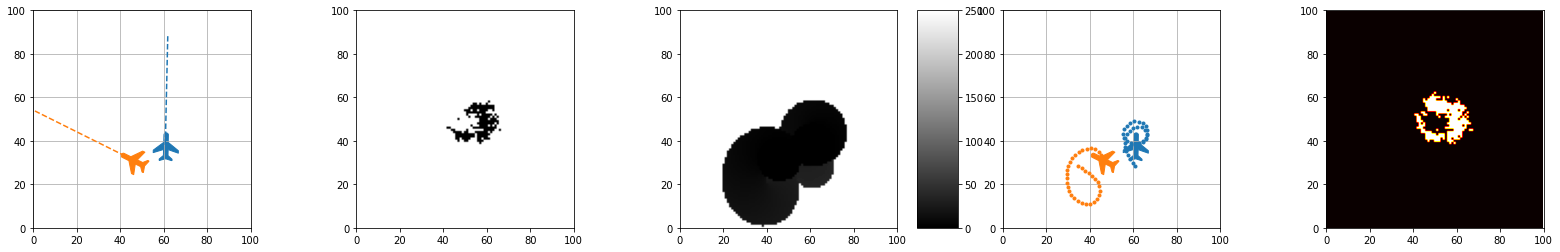

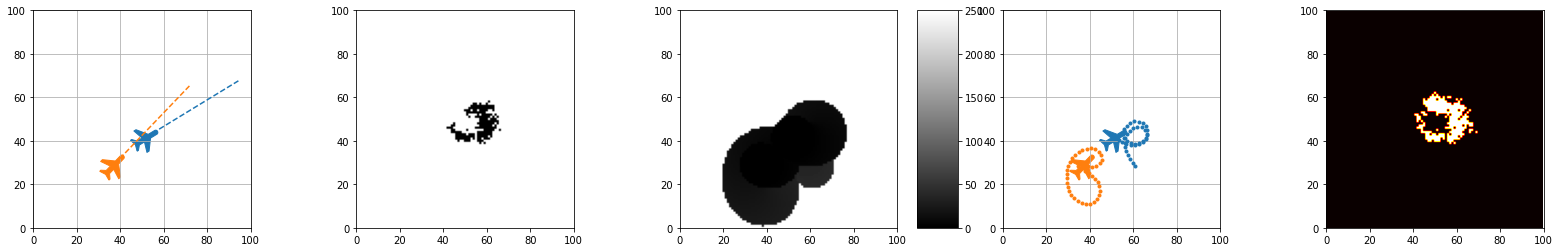

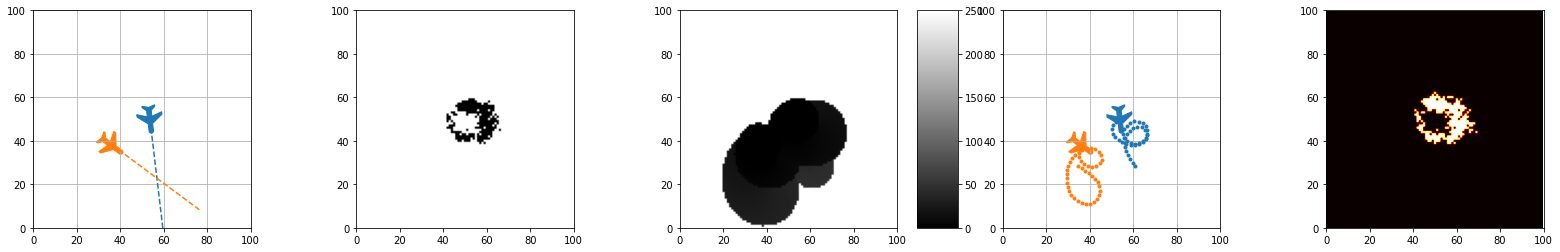

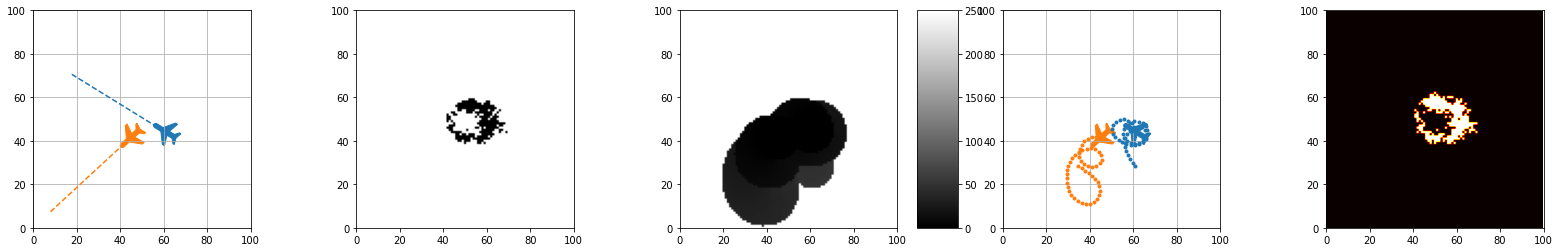

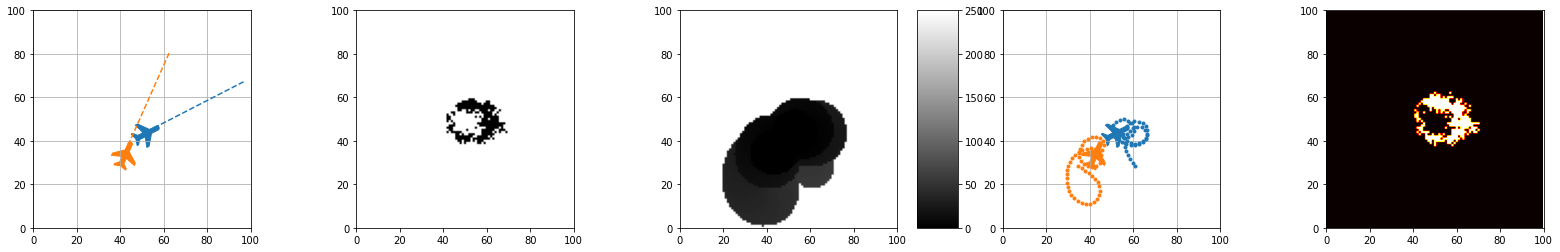

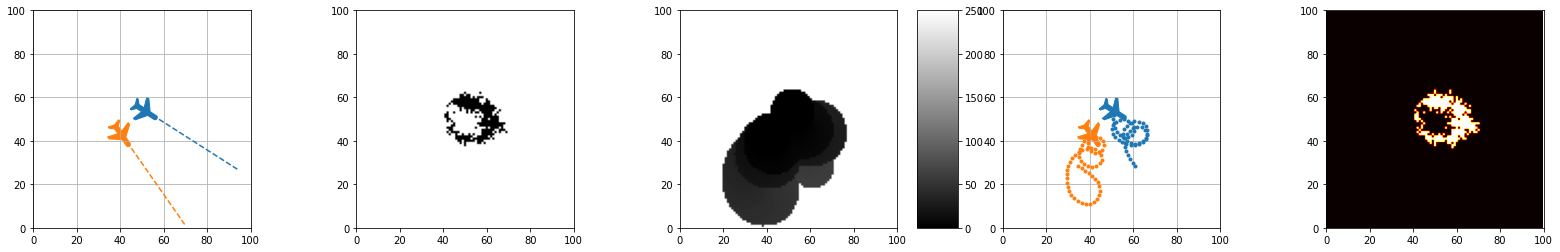

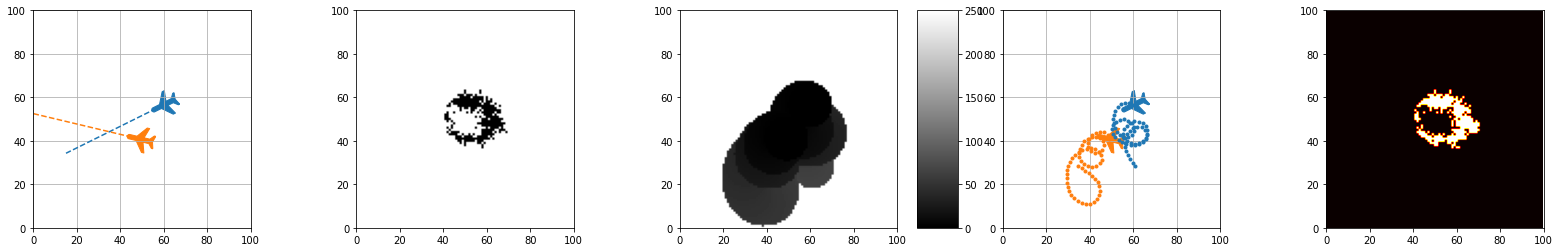

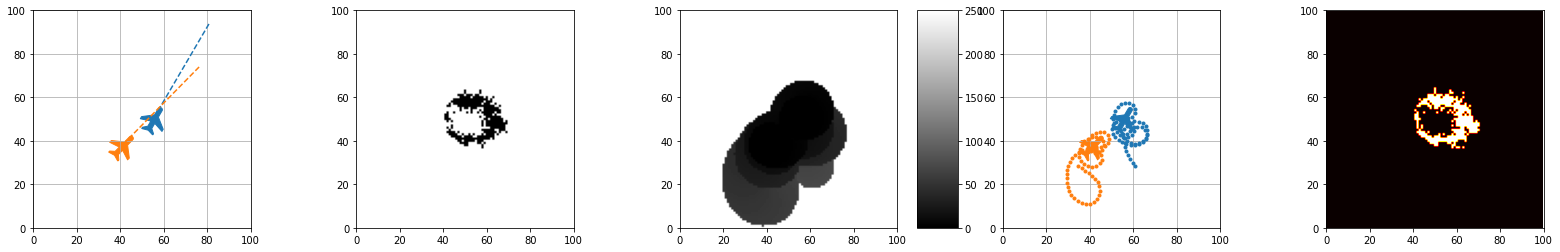

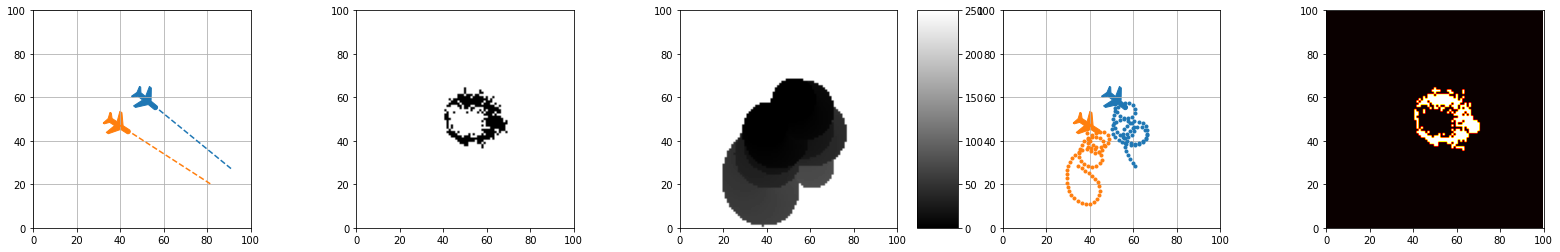

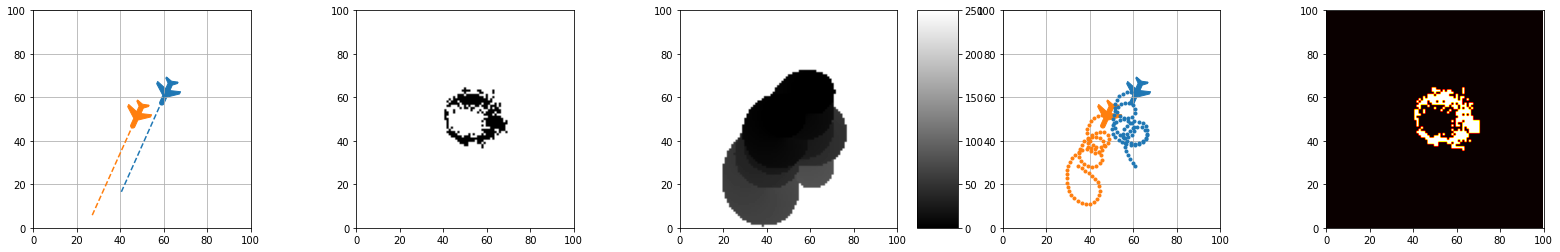

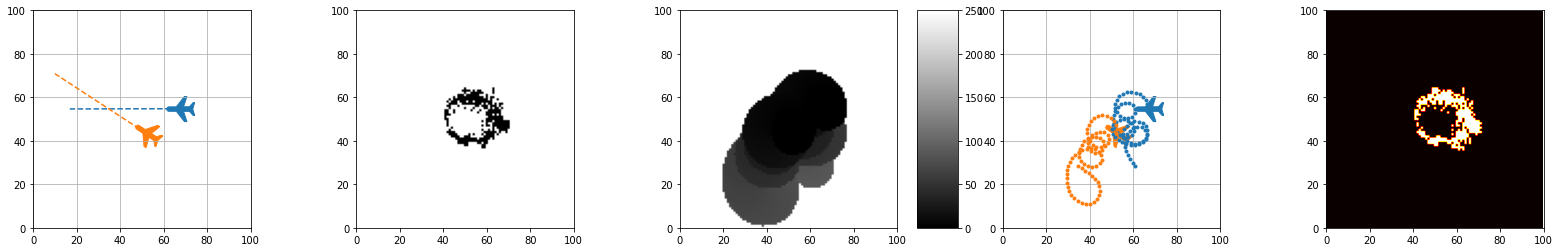

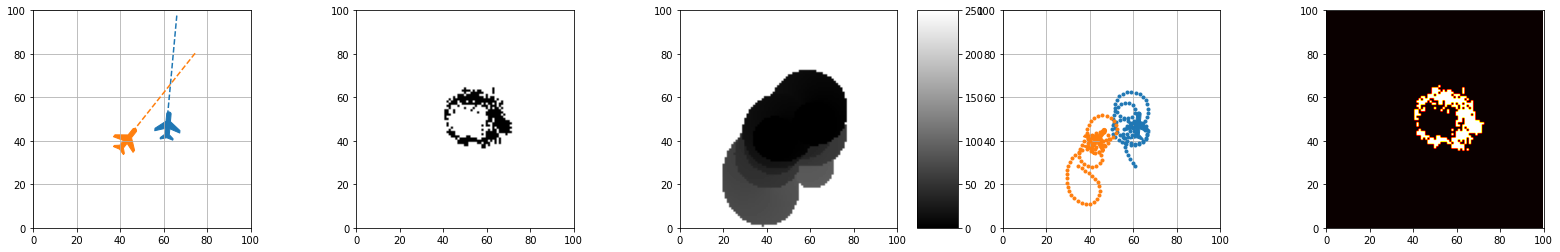

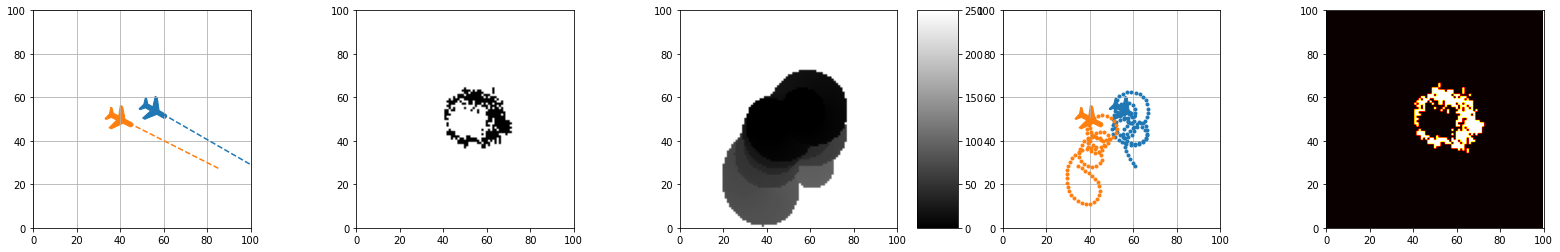

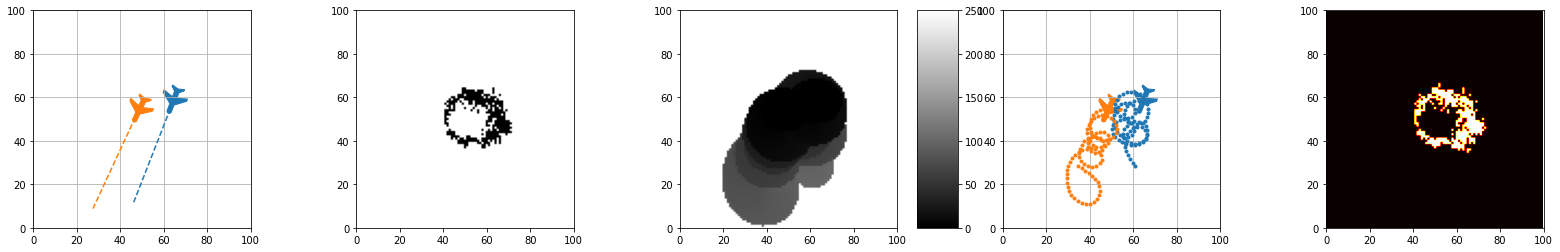

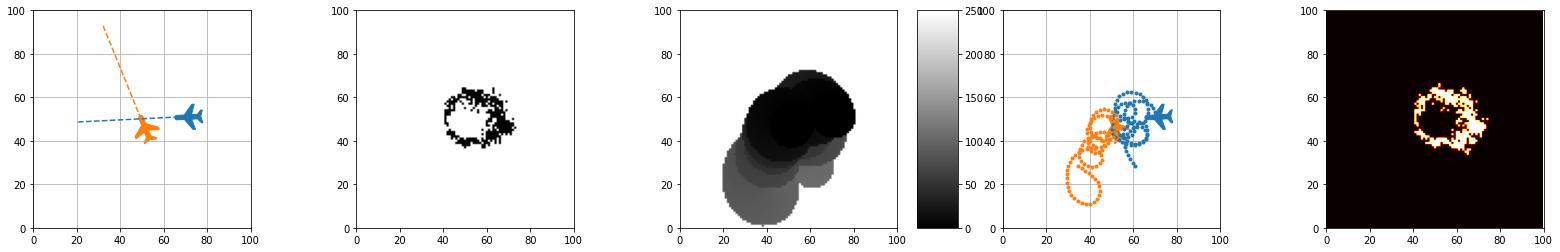

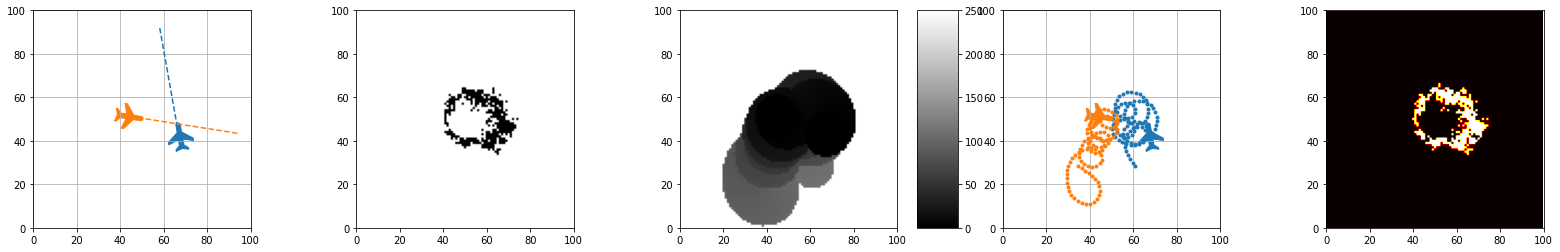

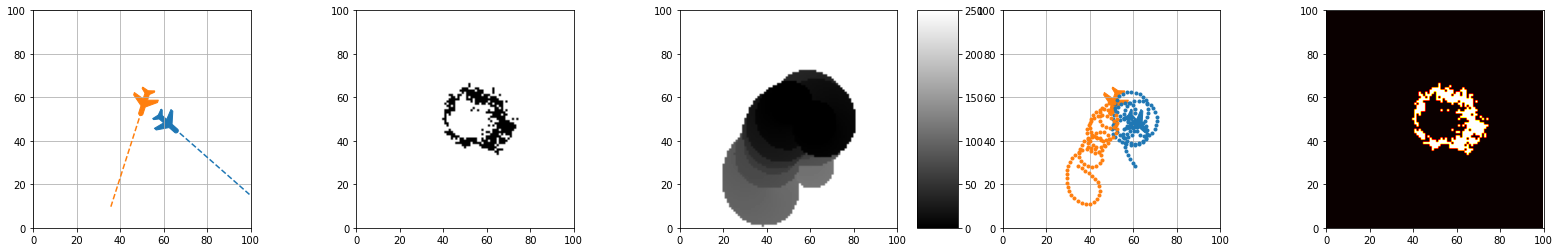

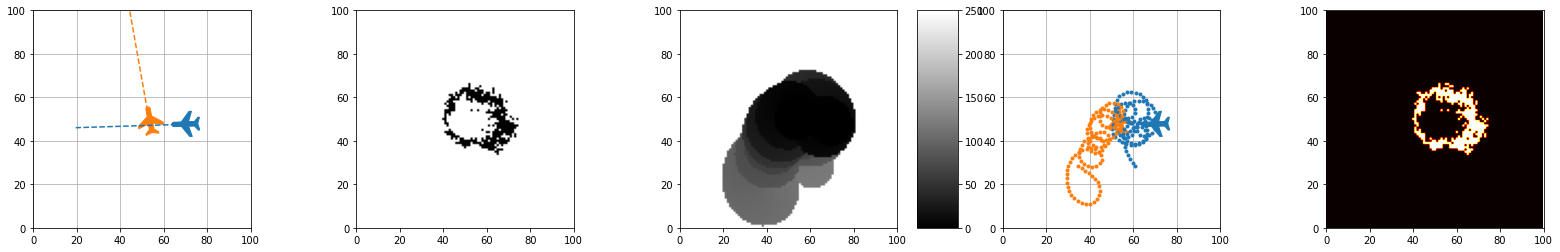

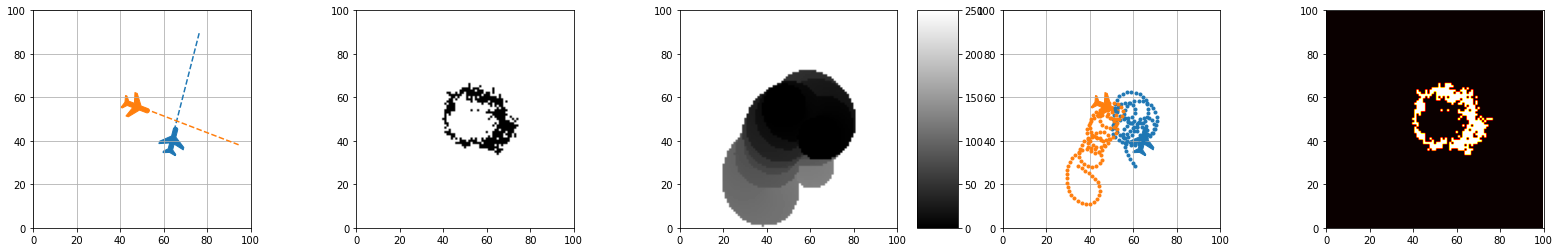

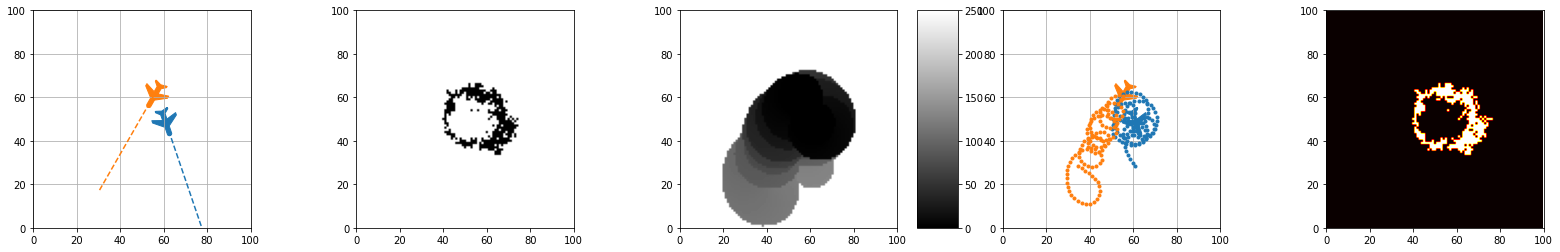

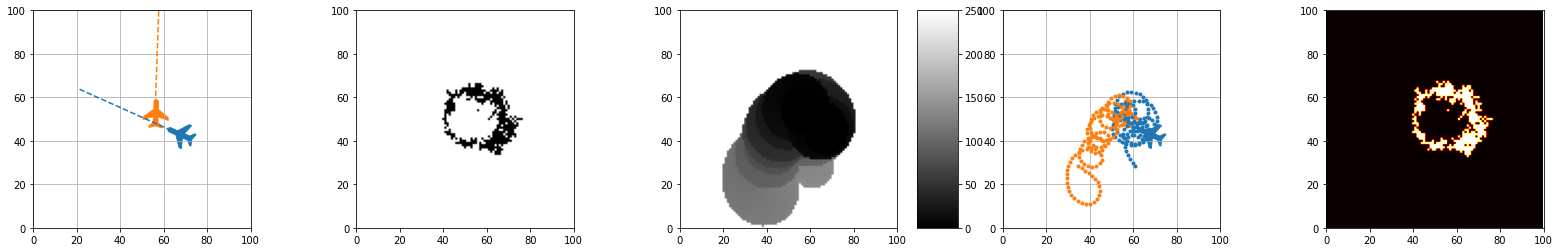

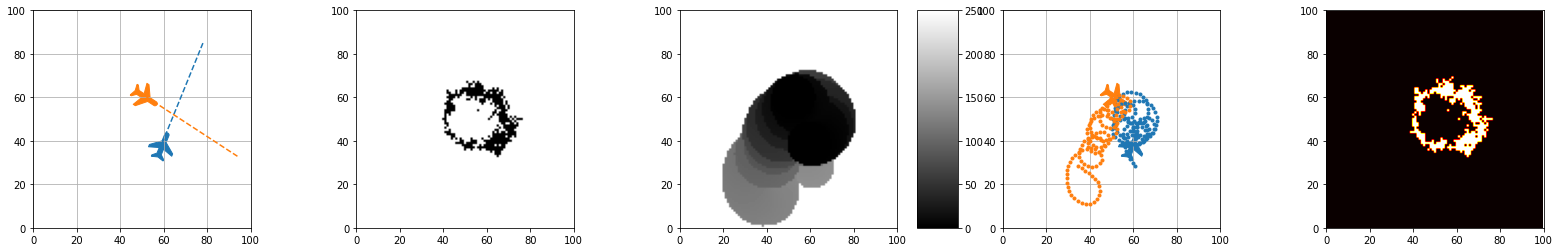

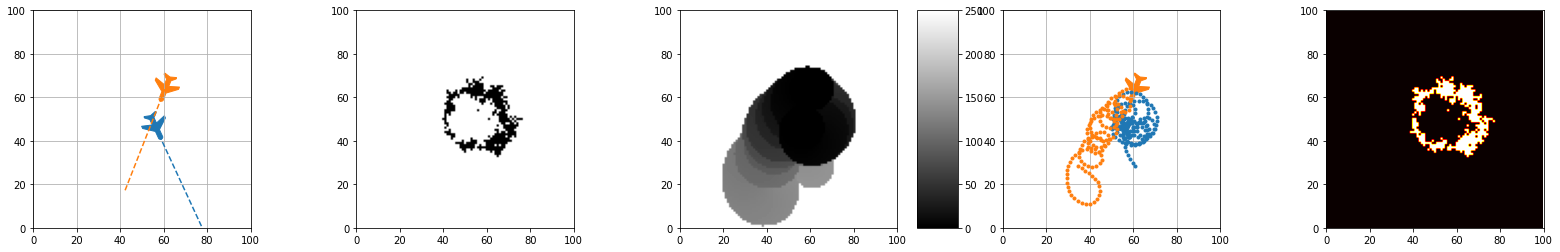

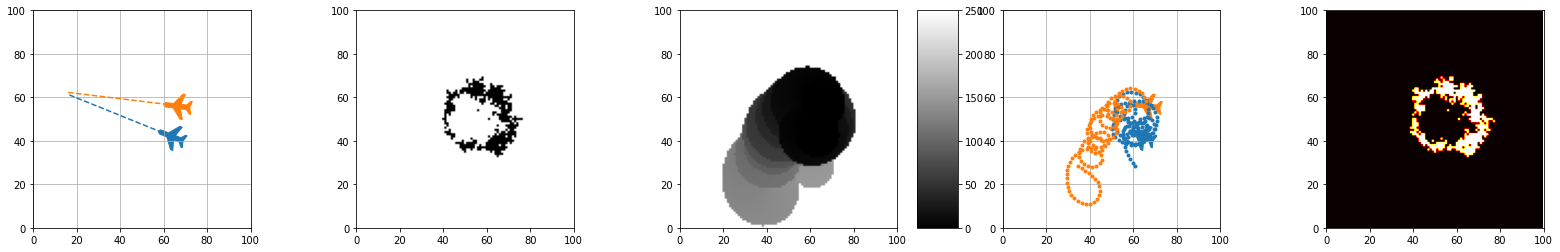

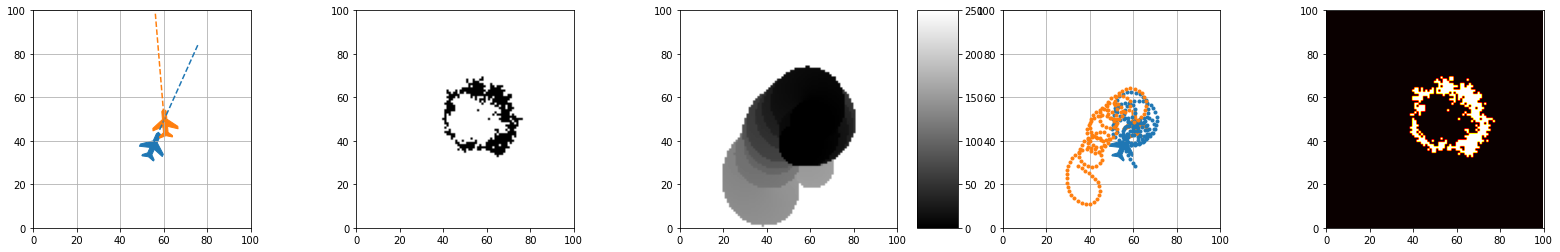

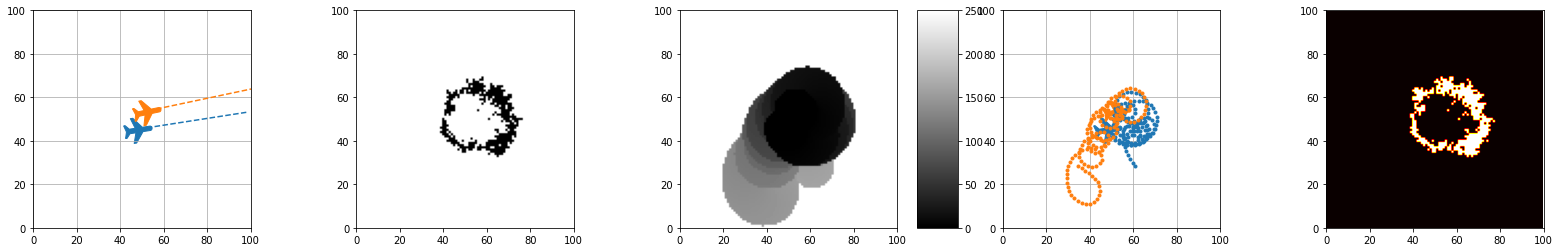

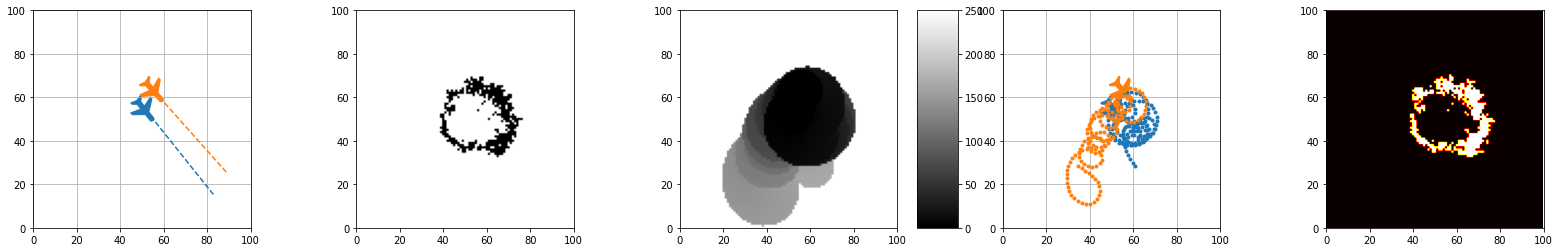

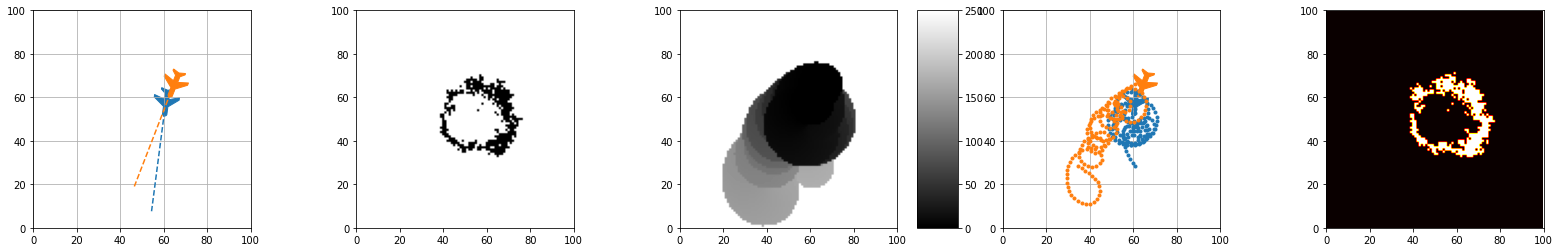

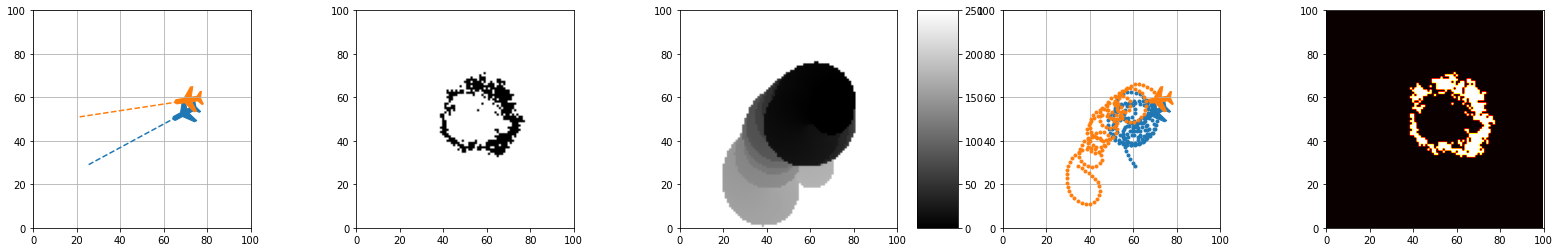

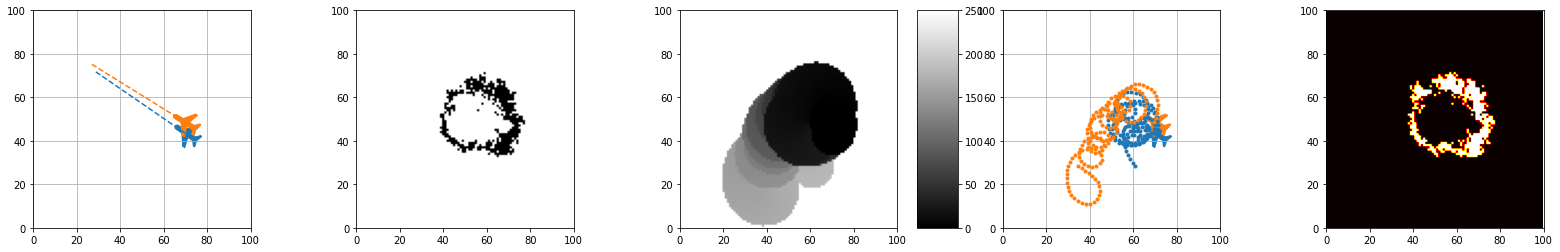

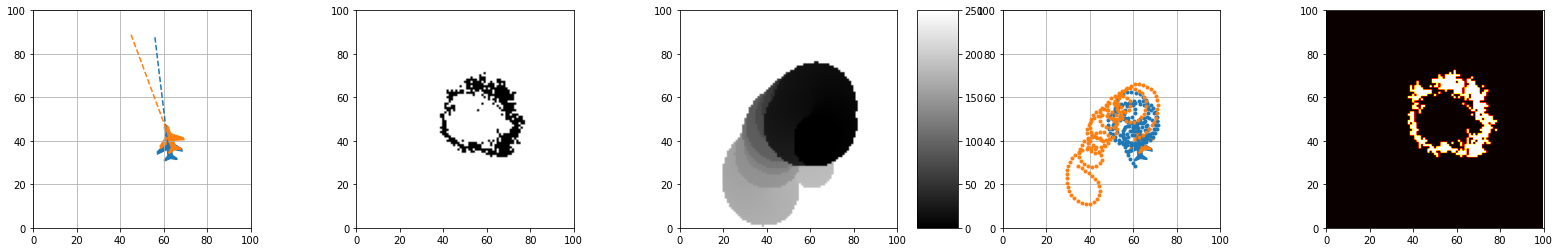

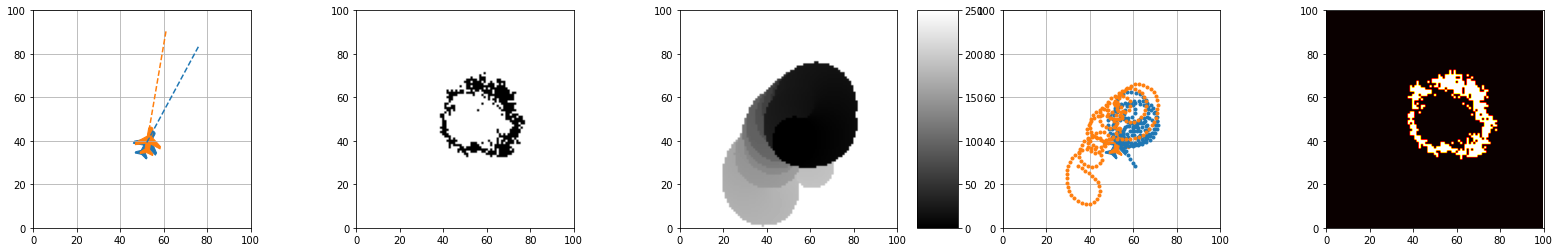

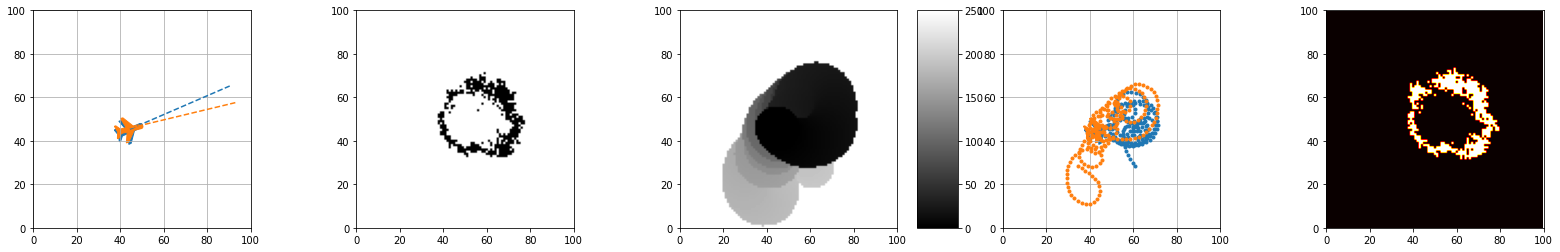

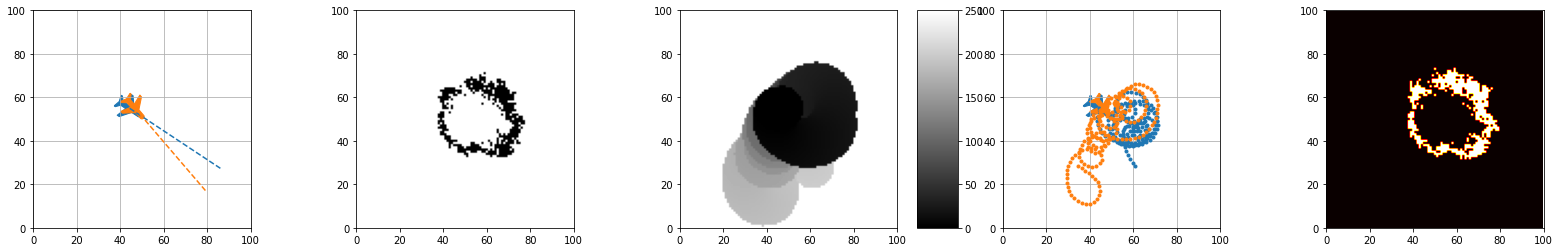

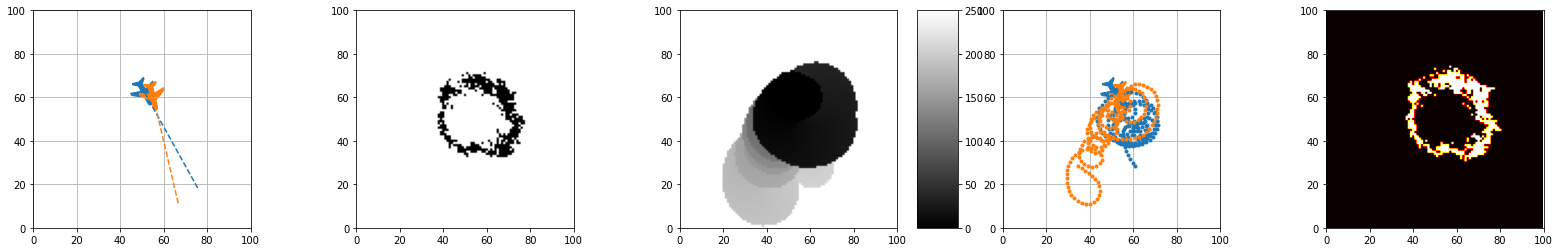

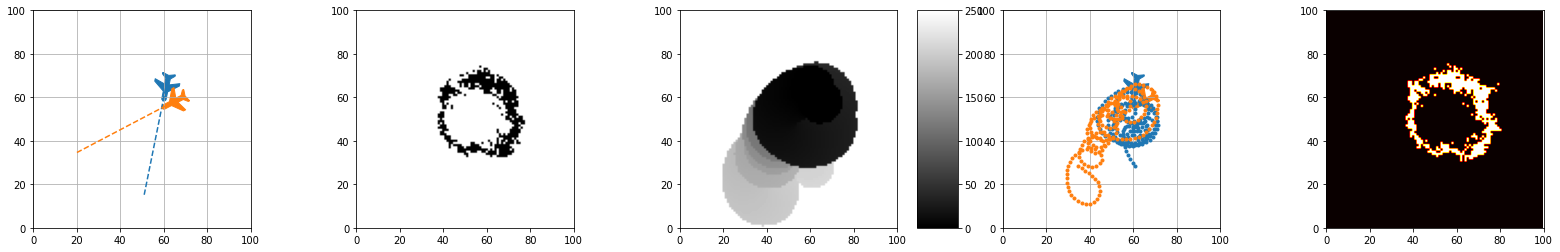

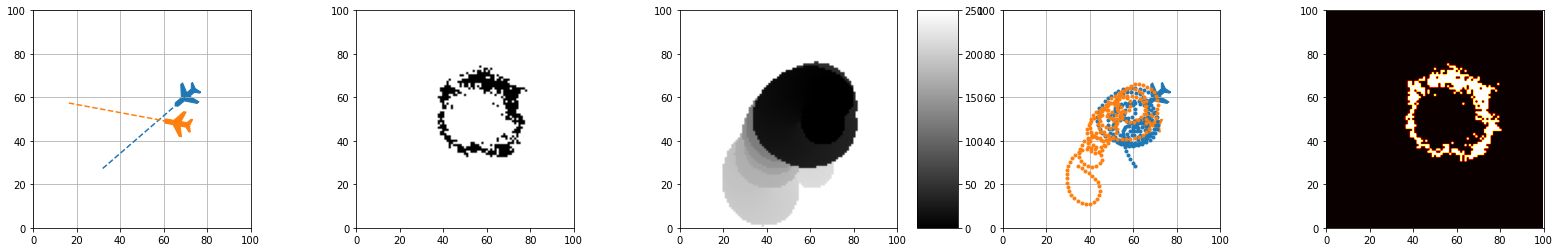

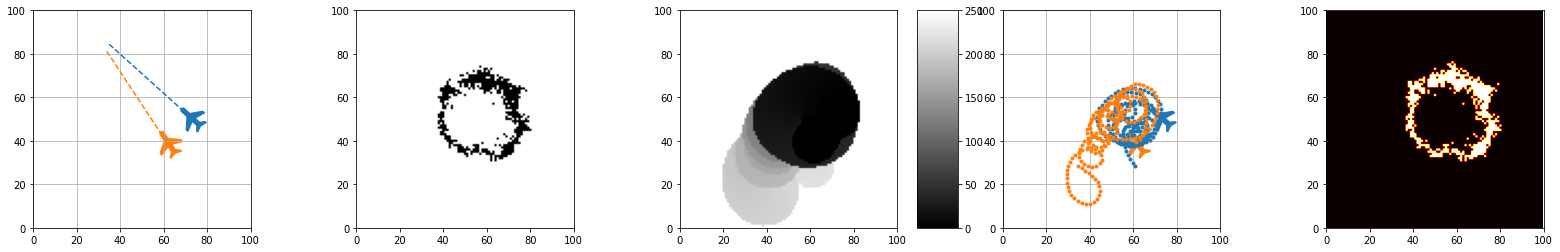

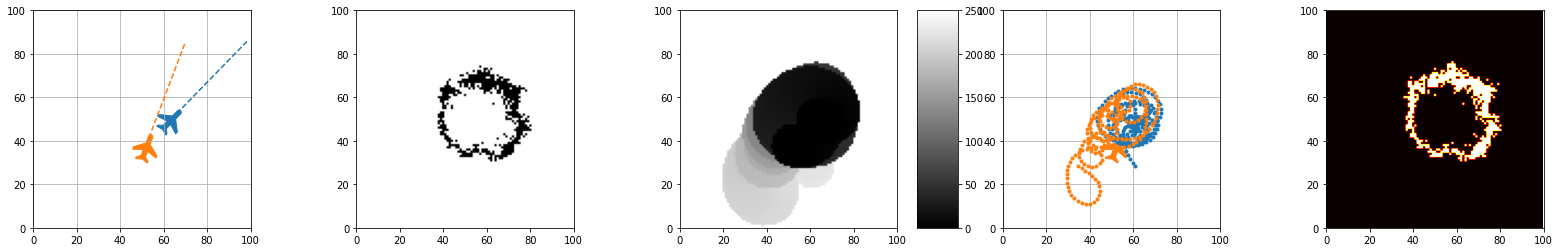

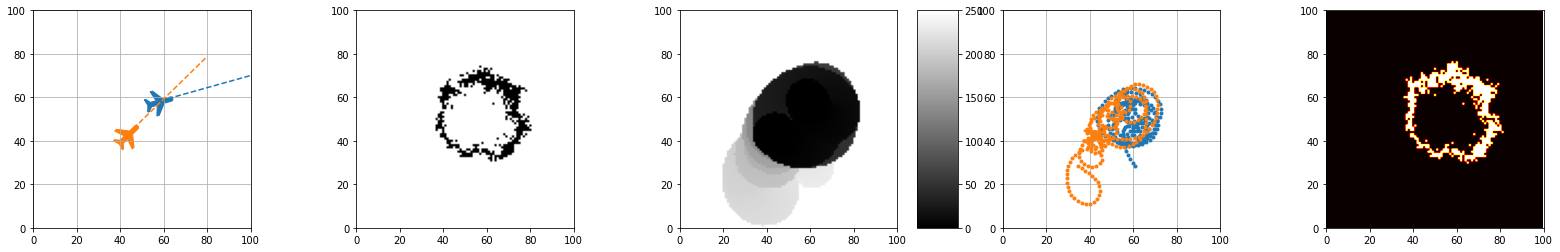

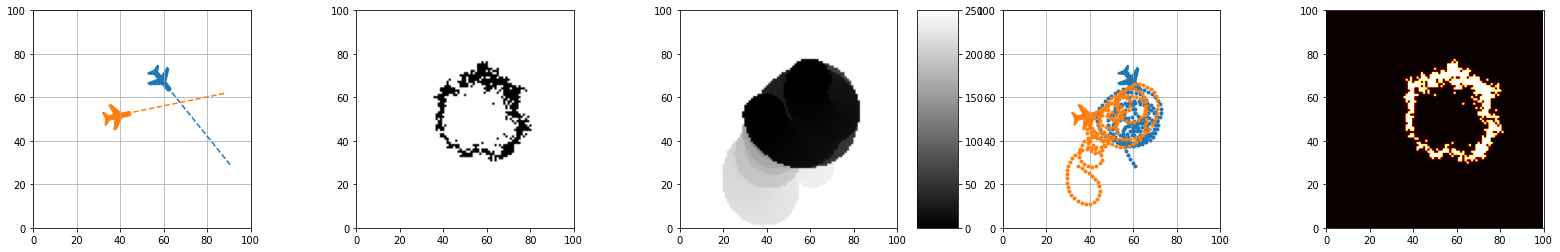

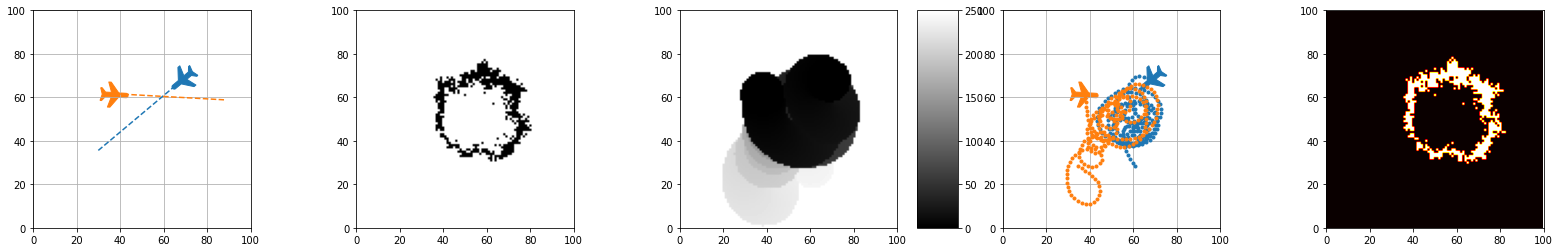

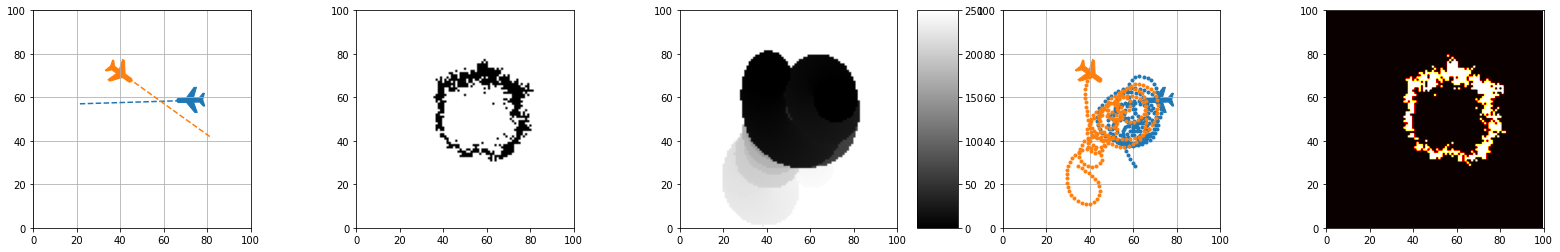

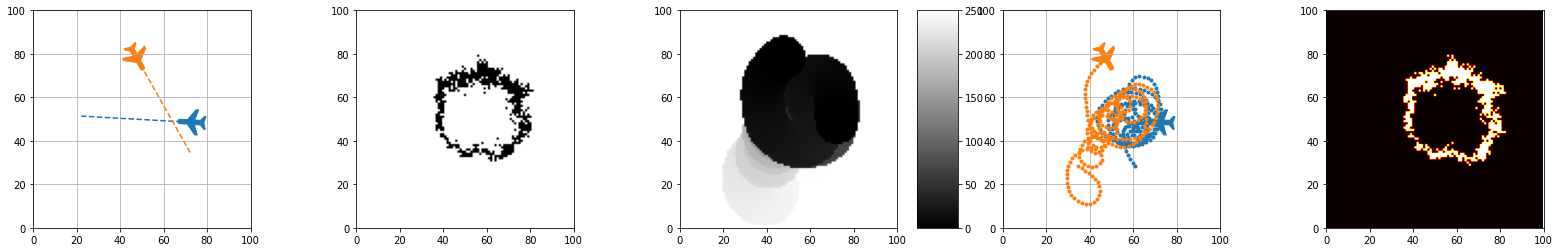

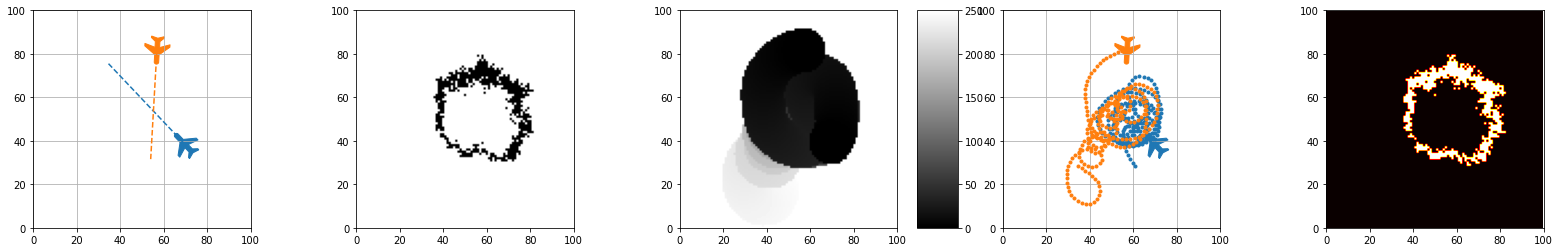

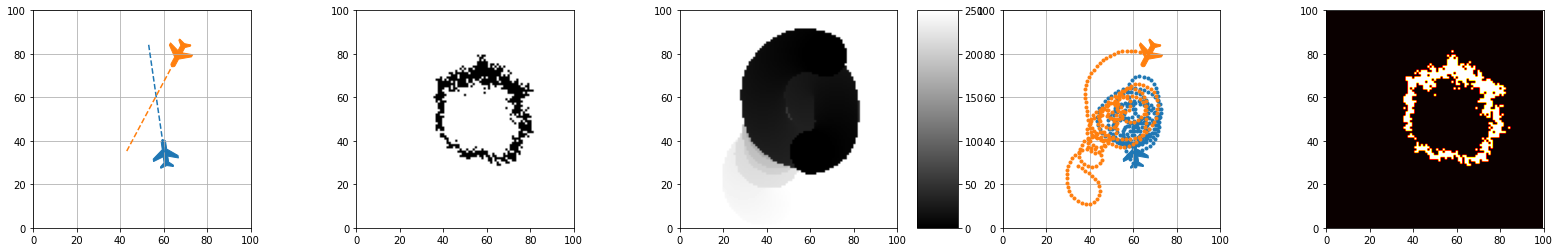

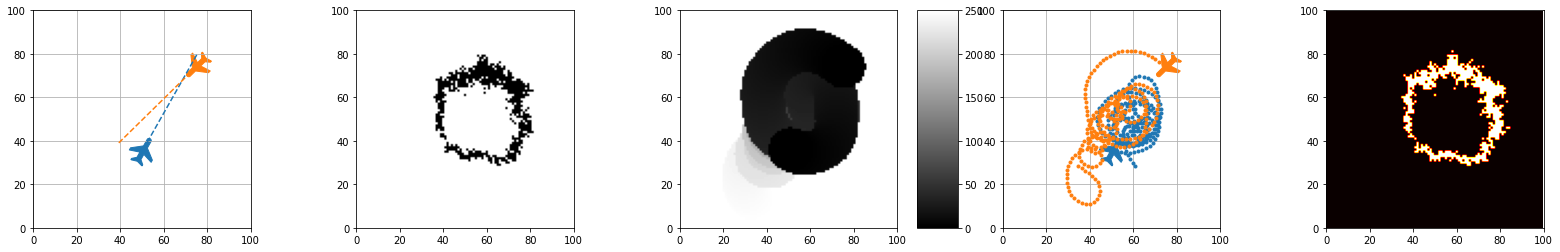

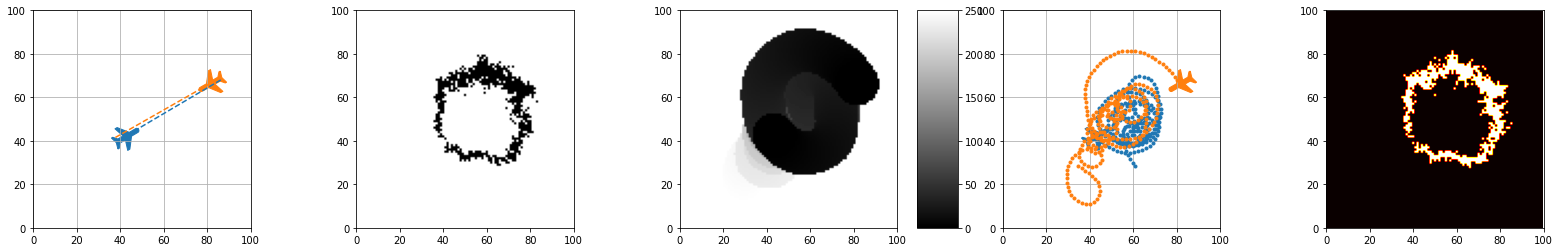

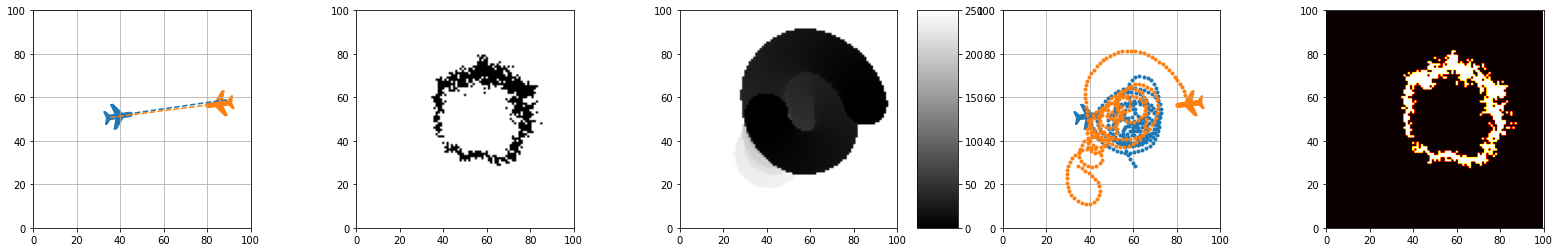

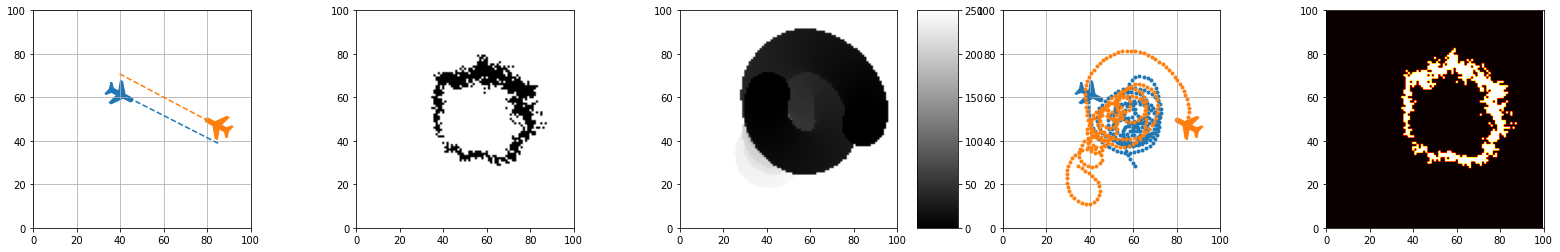

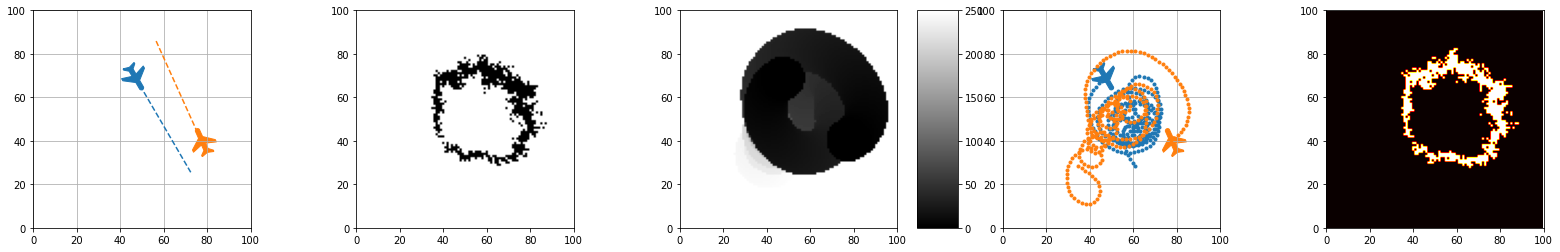

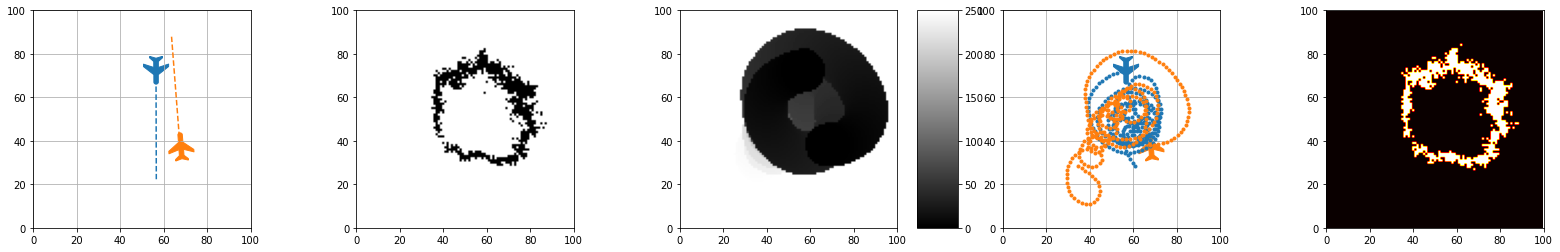

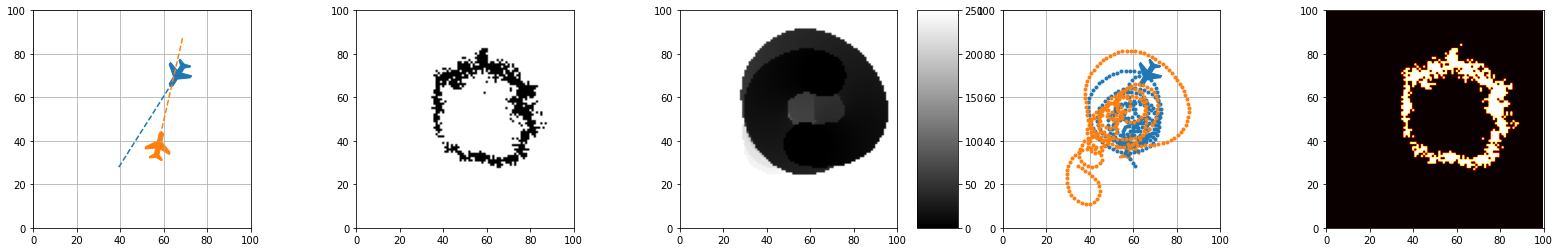

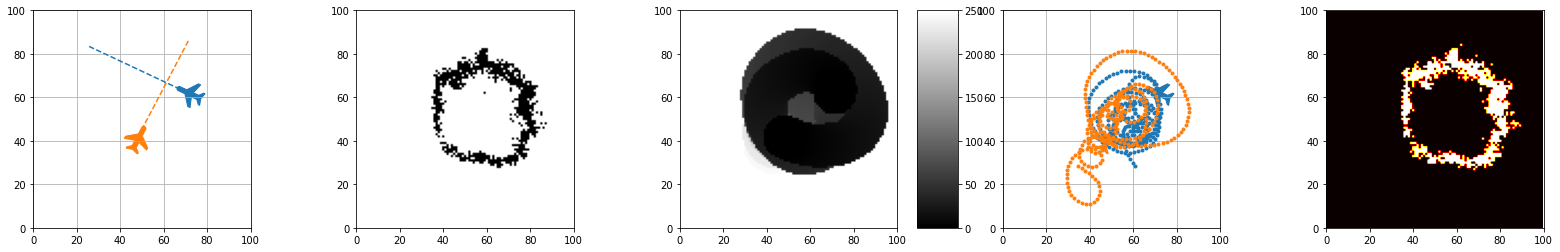

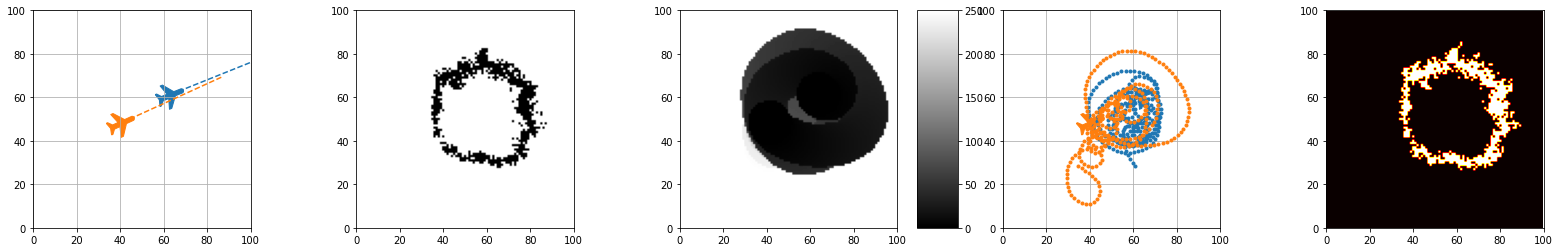

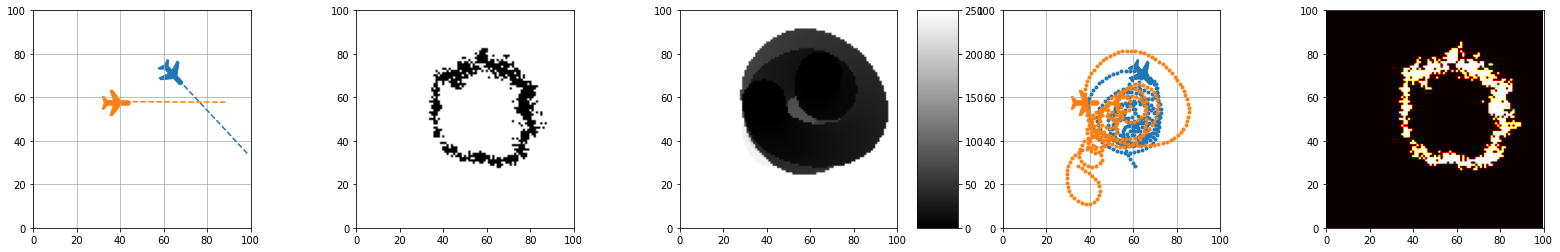

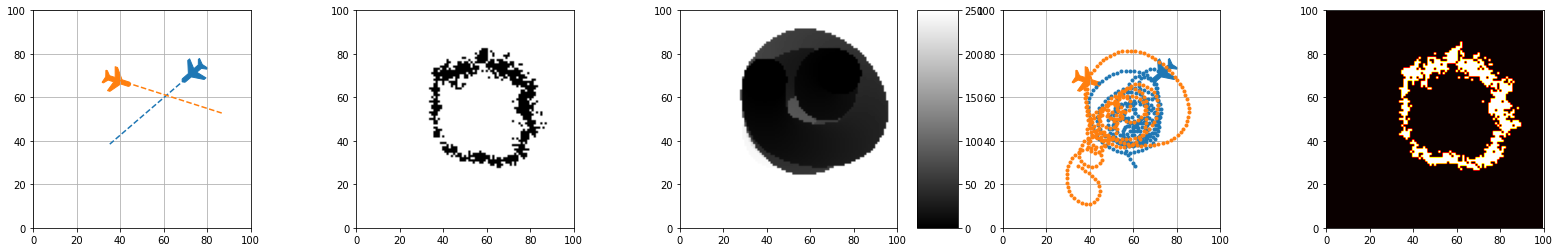

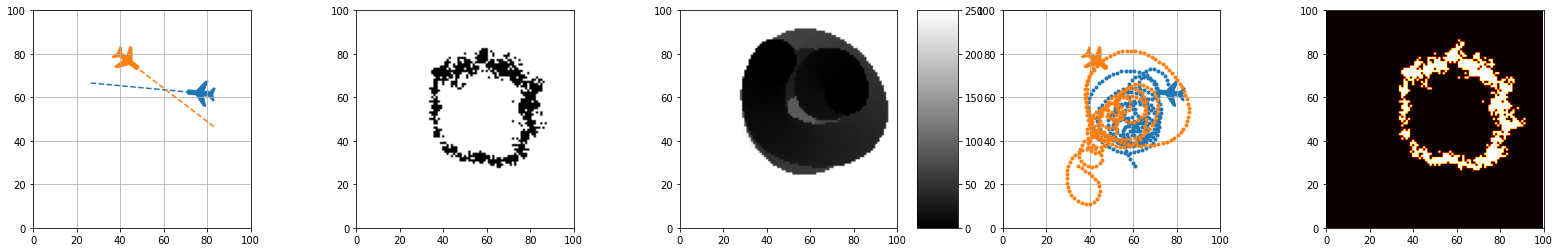

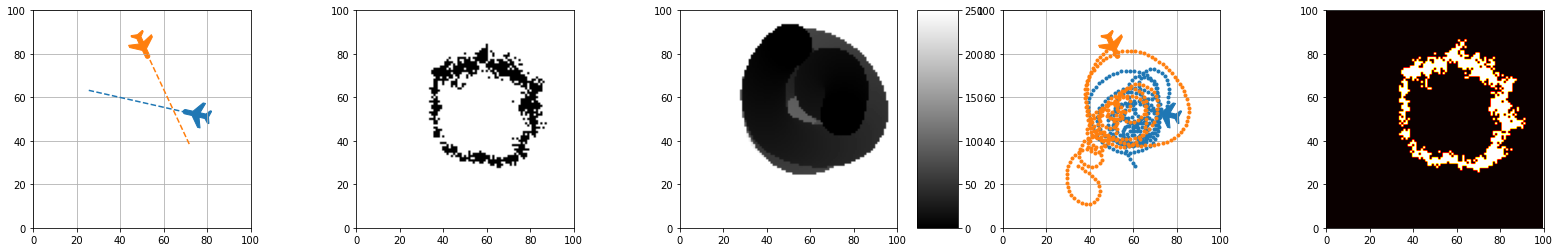

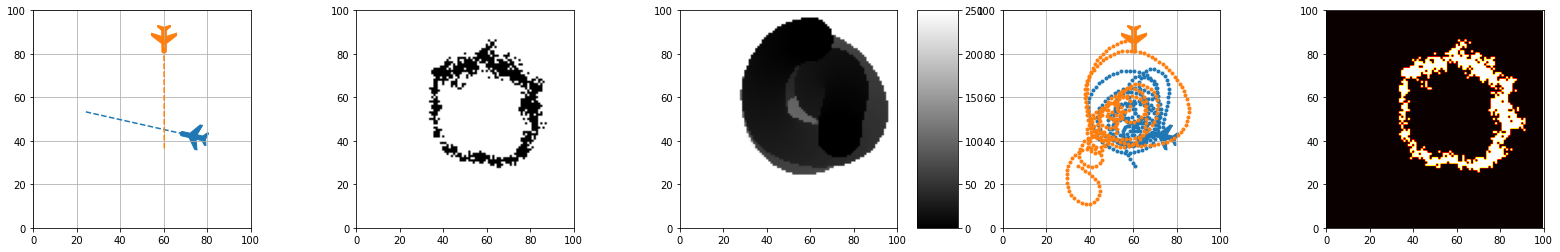

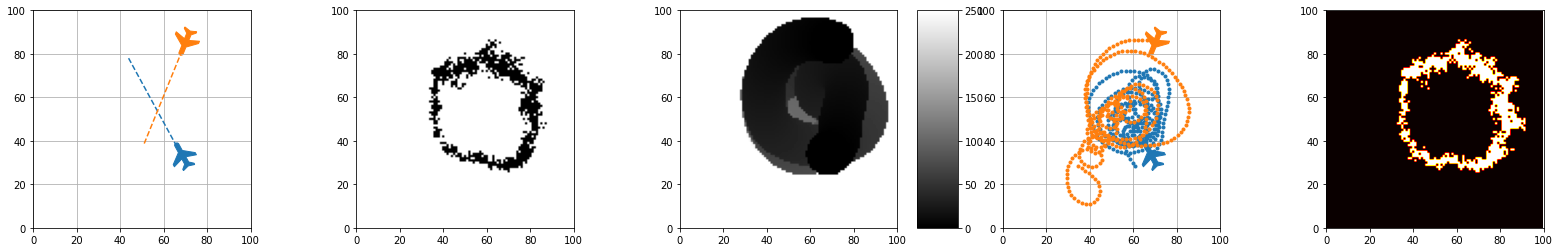

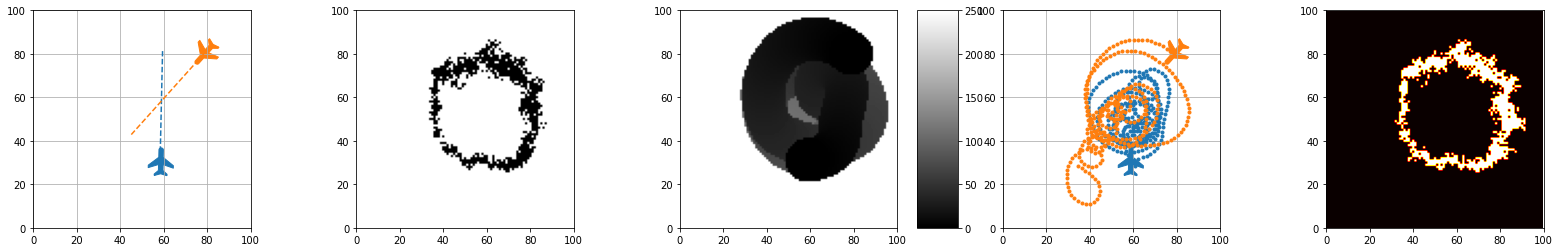

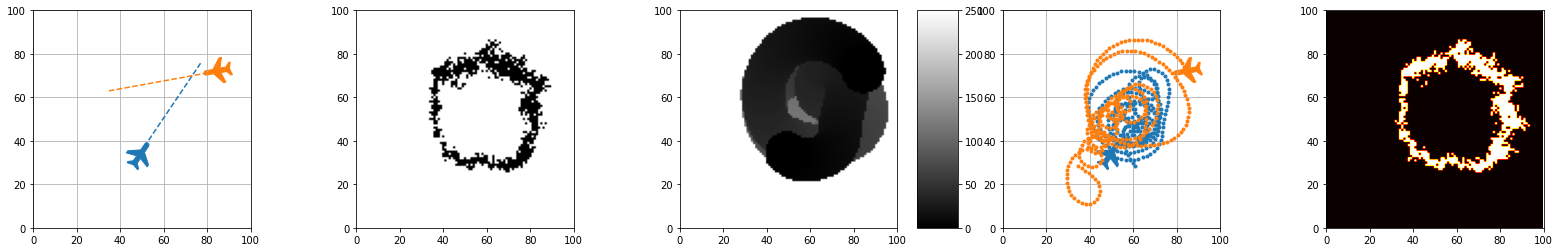

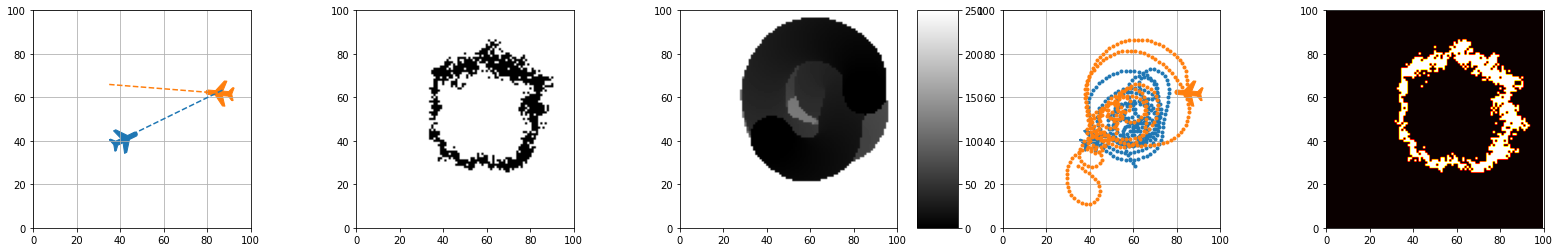

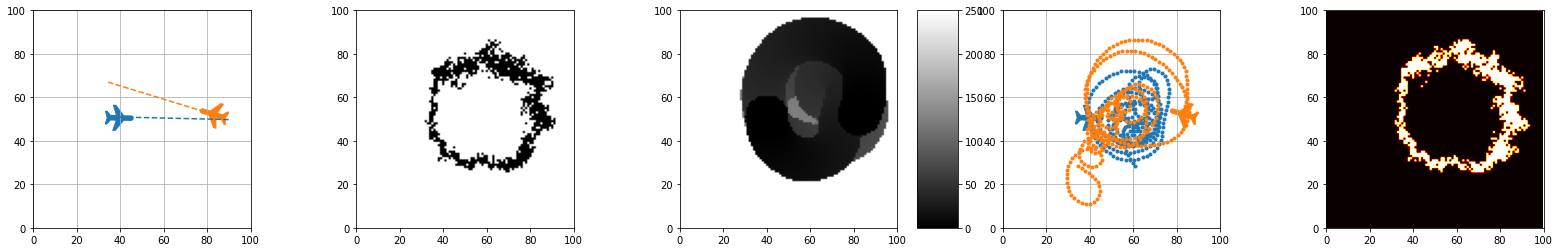

In [12]:
DT          = 0.5  # Time between wildfire updates            
DTI         = 0.1  # Time between aircraft decisions
fireEnv = ProbabilisticFireEnv(HEIGHT, WIDTH)
dronesEnv = DronesEnv(HEIGHT, WIDTH, DT, DTI) 
loss = None
i_episode = 1
images = []
seed, observation = fireEnv.reset()
dronesEnv.reset(seed, observation)



hidden_1 = None
hidden_2 = None

while True:


  state_vector_1 = dronesEnv.drones[0].state
  map_1 = dronesEnv.drones[0].observation
  state_vector_1 = torch.tensor(state_vector_1, dtype=torch.float)
  map_1 = torch.tensor(map_1,  dtype=torch.float)

  state_vector_2 = dronesEnv.drones[1].state
  map_2 = dronesEnv.drones[1].observation
  state_vector_2 = torch.tensor(state_vector_2, dtype=torch.float)
  map_2 = torch.tensor(map_2, dtype=torch.float)

  for i in range(int(DT/DTI)):
    action1, hidden_1 = select_action(map_1, state_vector_1, hidden_1)
    action2, hidden_2 = select_action(map_2, state_vector_2, hidden_2)
    rewards = dronesEnv.step([action1, action2], observation)

    next_state_vector_1 = dronesEnv.drones[0].state
    next_map_1 = dronesEnv.drones[0].observation

    next_state_vector_1 = torch.tensor(next_state_vector_1,  dtype=torch.float)
    next_map_1 = torch.tensor(next_map_1, dtype=torch.float)

    next_state_vector_2 = dronesEnv.drones[1].state
    next_map_2 = dronesEnv.drones[1].observation

    next_state_vector_2 = torch.tensor(next_state_vector_2,  dtype=torch.float)
    next_map_2 = torch.tensor(next_map_2, dtype=torch.float)


    state_vector_1 = next_state_vector_1
    state_vector_2 = next_state_vector_2

    map_1 = next_map_1
    map_2 = next_map_2



  observation = fireEnv.step()

  if not fireEnv.fire_in_range(6):
    break

  fig, ax = plt.subplots(1, 5, figsize=(28, 4))
  dronesEnv.plot_drones(fig, ax[0])
  dronesEnv.plot_belief_map(fig, ax[1])
  dronesEnv.plot_time_elapsed(fig, ax[2])
  dronesEnv.plot_trajectory(fig, ax[3])
  fireEnv.plot_heat_map(fig, ax[4])

  fig.canvas.draw() 
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
  image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  images.append(image)
kwargs_write = {'fps':5.0, 'quantizer':'nq'}
imageio.mimsave('./drqn_example.gif', images, fps=5)